## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [81]:
calibration_folder = './camera_cal'
output_folder = './output_images'

### Extracting Points

In [62]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
full_path = calibration_folder + '/calibration*.jpg'
images = glob.glob(full_path)

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(100)

cv2.destroyAllWindows()



### Calibrating

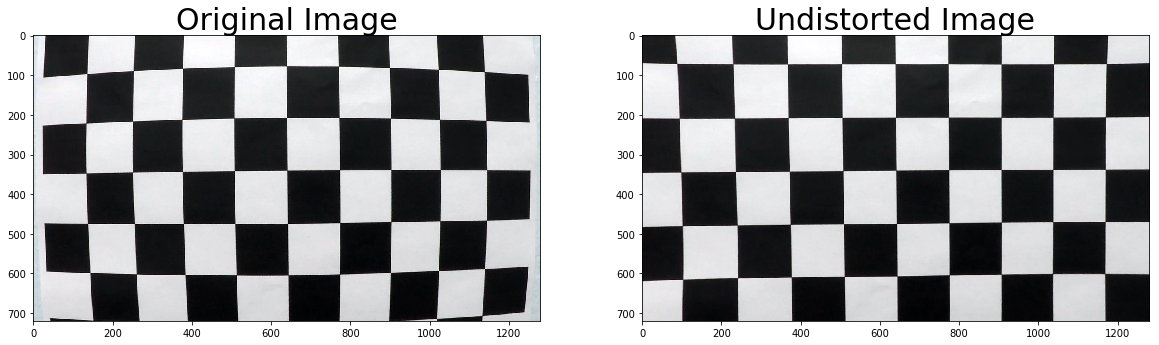

In [63]:
import pickle
%matplotlib inline

# Test undistortion on an image
test_image_path = calibration_folder + '/calibration1.jpg'
img = cv2.imread(test_image_path)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
undistort_path = calibration_folder + '/test_undist.jpg'
cv2.imwrite(undistort_path,dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist

pickle_path = calibration_folder + '/wide_dist_pickle.p'
pickle.dump( dist_pickle, open( pickle_path, "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Lane Detection Pipeline

### Utils

In [85]:
import matplotlib.pyplot as plt

def plot_image(index, img, title, mode = 'RBG', points = []):   
    if (mode is 'BGR'):
        aux_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        aux_img = img
    
    plt.figure(index)
    
    if (mode is 'GRAY'):
        plt.imshow(aux_img, cmap='gray')
    else:
        plt.imshow(aux_img)
        
    plt.title(title, fontsize=30)
    
    for p in points:
        x = p[0]
        y = p[1]
        plt.plot(x,y, "o")
    #cv2.imshow(title,aux_img)

def squared_points(src, top = 0):
    bottom_left = src[0]
    bottom_right = src[1]
    top_left = src[2]
    top_right = src[3]
    
    new_bottom_left = [300,top]
    new_bottom_right = [1000,top]
    #new_top_left = [bottom_left[0],top_left[1]]
    #new_top_right = [bottom_right[0],top_right[1]]
    new_top_left = [bottom_left[0],top]
    new_top_right = [bottom_right[0],top]
    
    squared = []
    squared.append(new_bottom_left)
    squared.append(new_bottom_right)
    squared.append(new_top_left)
    squared.append(new_top_right)

    return squared
    

### Image PlayGround

In [86]:
import numpy as np

def undistort_image(distorted_img, camera_matrix, distortion_coeffs):
    return cv2.undistort(distorted_img, camera_matrix, distortion_coeffs, None, camera_matrix)


def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def to_saturation(img, thresh = (90, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    dx = 1
    dy = 0
    if orient == 'y':
        dx = 0
        dy = 1
    
    sobel = cv2.Sobel(img, cv2.CV_64F, dx, dy, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sxbinary

def sobel_magnitude(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel)
    #abs_sobel = np.absolute(sobelx+sobely)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary

def sobel_direction(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def sobel_combined(img):
    ksize = 3
    gradx = sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(100, 255))
    grady = sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(100, 255))
    mag_binary = sobel_magnitude(img, sobel_kernel=ksize, mag_thresh=(30, 255))
    dir_binary = sobel_direction(img, sobel_kernel=15, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


    return combined

def perspective_transform_full_process(img, src,dst):
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped;

def perspective_transform(img, src,dst, M, image_size):
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped;



### Load Test Image

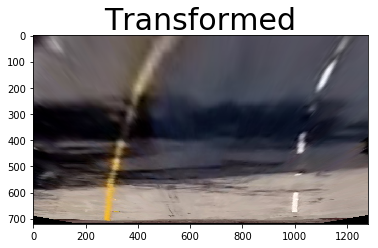

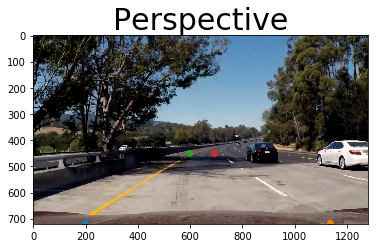

In [87]:
import cv2
import pickle

test_image_folder = './test_images'
#test_image_path = test_image_folder + '/straight_lines1.jpg'
test_image_path = test_image_folder + '/test5.jpg'
test_image = cv2.imread(test_image_path)

calibration_folder = './camera_cal'
pickle_path = calibration_folder + '/wide_dist_pickle.p'
dist_pickle = pickle.load( open( pickle_path, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

plot_image(0,test_image, 'Original', mode = 'BGR')

undistorted_img = undistort_image(test_image, mtx, dist)

plot_image(1,undistorted_img, 'Undistorted', mode = 'BGR')
cv2.imwrite(output_folder + '/undistorted_road.png' ,undistorted_img)

color_threshold = to_saturation(undistorted_img, thresh = (170, 255))
plot_image(2,color_threshold, 'Color Threshold', mode = 'GRAY')

sobel = sobel_thresh(color_threshold, orient='x', sobel_kernel=3, thresh=(20, 100))

plot_image(3,sobel, 'Sobel', mode = 'GRAY')

sobel_mag = sobel_magnitude(color_threshold, sobel_kernel=3, mag_thresh=(100, 255))
plot_image(4,sobel_mag, 'Sobel Magnitude', mode = 'GRAY')


sobel_dir = sobel_direction(color_threshold, sobel_kernel=15, thresh=(0.7, 1.3))
plot_image(5,sobel_dir, 'Sobel Direction', mode = 'GRAY')

sobel_comb = sobel_combined(color_threshold)
plot_image(6,sobel_comb, 'Sobel Combined', mode = 'GRAY')

# = [[280,670],[1034, 670],[560,475],[725,475]]
p = [[197,715],[1136, 715],[594,447],[691,447]]

plot_image(7,test_image, 'Perspective', mode = 'BGR', points = p)


src = np.float32(p)
#dest = np.float32([[280,670],[1034, 670],[280,0],[1034,0]])
#dest = np.float32([p[0],p[1],[280,0],[1034,0]])
#dest = np.float32(squared_points(src, top = 0))

bottom_left = src[0]
bottom_right = src[1]
top_left = src[2]
top_right = src[3]
    
new_bottom_left = [300,bottom_left[1]]
new_bottom_right = [1000,bottom_right[1]]
new_top_left = [300,0]
new_top_right = [1000,0]
    
dest = []
dest.append(new_bottom_left)
dest.append(new_bottom_right)
dest.append(new_top_left)
dest.append(new_top_right)
dest = np.float32(dest)


perspective_trasformed = perspective_transform_full_process(test_image, src, dest)
plot_image(8,perspective_trasformed, 'Transformed', mode = 'BGR')




### Test full Preprocess

In [67]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def image_preprocess(img, camera_matrix, distortion_coeffs, M, image_size):
    undistorted_img = undistort_image(test_image, camera_matrix, distortion_coeffs)
    thresholded_image, binary = pipeline(img, s_thresh=(200, 255), r_thresh = (200, 255), sx_thresh=(20, 100))
    perspective_trasformed = perspective_transform(binary, src, dest, M, image_size)
    return perspective_trasformed

def pipeline(img, s_thresh=(170, 255), r_thresh = (200, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    r_channel = img[:,:,0]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    color_binary = np.dstack((r_binary, sxbinary, s_binary))

        
    combined = np.zeros_like(s_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((sxbinary == 1) | ((s_binary == 1) & (r_binary == 1)))] = 1

    return color_binary, combined

[[197, 715], [1136, 715], [594, 447], [691, 447]]


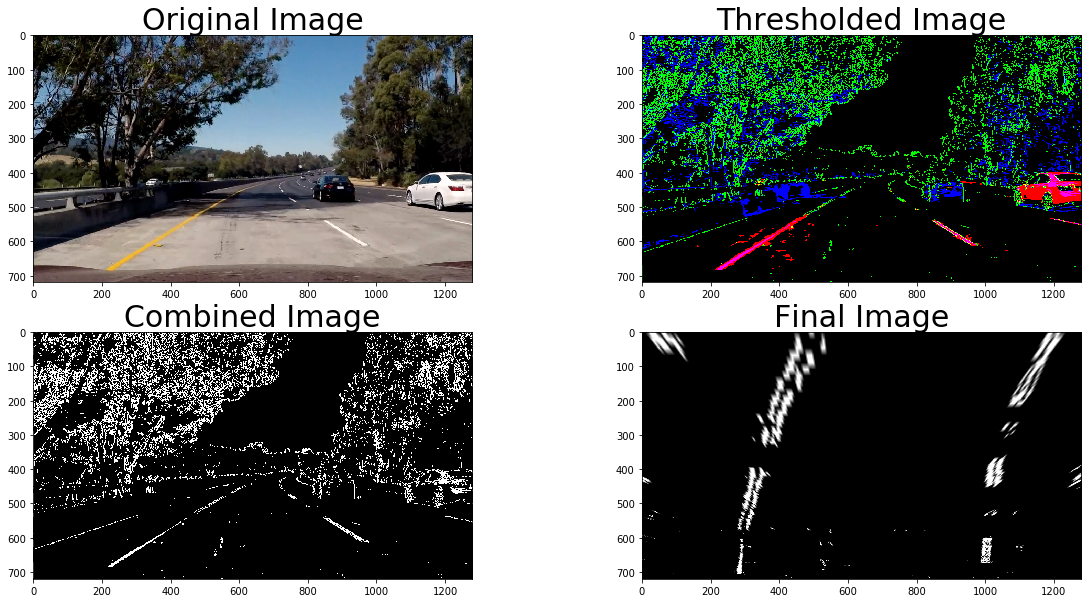

In [84]:
test_image_folder = './test_images'
test_image_path = test_image_folder + '/test5.jpg'
test_image = mpimg.imread(test_image_path)

calibration_folder = './camera_cal'
pickle_path = calibration_folder + '/wide_dist_pickle.p'
dist_pickle = pickle.load( open( pickle_path, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

print(p)
src = np.float32(p)
bottom_left = src[0]
bottom_right = src[1]
top_left = src[2]
top_right = src[3]
    
new_bottom_left = [300,bottom_left[1]]
new_bottom_right = [1000,bottom_right[1]]
new_top_left = [300,0]
new_top_right = [1000,0]
    
dest = []
dest.append(new_bottom_left)
dest.append(new_bottom_right)
dest.append(new_top_left)
dest.append(new_top_right)
dest = np.float32(dest)

M = cv2.getPerspectiveTransform(src, dest)
Minv = cv2.getPerspectiveTransform(dest, src)
img_size = (test_image.shape[1], test_image.shape[0])

result, result_binary = pipeline(test_image, s_thresh=(200, 255), r_thresh = (200, 255), sx_thresh=(20, 100))
final_result = image_preprocess(test_image, mtx, dist, M, img_size)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(result)
ax2.set_title('Thresholded Image', fontsize=30)
ax3.imshow(result_binary, cmap = 'gray')
ax3.set_title('Combined Image', fontsize=30)
ax4.imshow(final_result, cmap = 'gray')
ax4.set_title('Final Image', fontsize=30)

## Lane Detection

### Playground

### Sliding Window

314
1010


(720, 0)

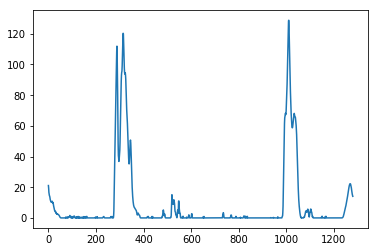

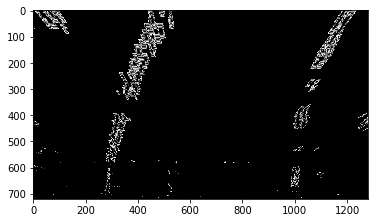

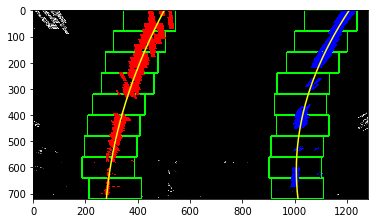

In [88]:
import numpy as np

binary_warped = final_result

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

plt.figure(0)
plt.plot(histogram)

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print(leftx_base)
print(rightx_base)


plt.figure(1)
plt.imshow(out_img)


# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,1,0), 4) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,1,0), 4) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
plt.figure(2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Polynomial

(720, 0)

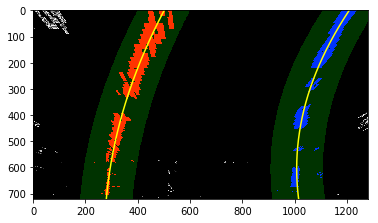

In [89]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Curvature

In [78]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

print(ploty.shape)
print(leftx.shape)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radius of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
curvature = (left_curverad+right_curverad)/2

print(left_curverad, 'm', right_curverad, 'm')

center_img = binary_warped.shape[1]/2
left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
center_lane = (left_x + right_x)/2
diff_pixels = center_img - center_lane
diff_meters = diff_pixels*xm_per_pix
print(left_x, right_x)
print(center_img, center_lane,diff_pixels)

print(diff_pixels*xm_per_pix)

4780.06363571 14686.8341668
(720,)
(32913,)
1529.74262618 m 4766.27858753 m
7.94996393254 1037.33498114
640.0 522.642472535 117.357527465
0.62031835946


### Draw In image

Radius of Curvature = 3148.01 (m)
Vehicle is 0.62 (m) right of center


True

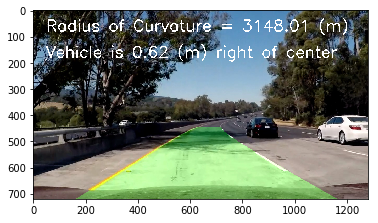

In [93]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(test_image, 1, newwarp, 0.3, 0)


radius_str = 'Radius of Curvature = ' + "{:3.2f}".format(curvature) + ' (m)'
side_str = "right" if diff_meters>0 else "left"
diff_str = "{:3.2f}".format(abs(diff_meters))
position_str = 'Vehicle is ' + diff_str + ' (m) ' + side_str + ' of center'
print(radius_str)
print(position_str)


font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result,radius_str,(50, 80), font, 2,(255,255,255),3)
cv2.putText(result,position_str,(50, 180), font, 2,(255,255,255),3)

rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
cv2.imwrite(output_folder + '/final_result.png' ,result)

## Final PipeLine

In [6]:
import numpy as np


class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def evaluate(self, y):
        coef_2 = self.current_fit[0]
        coef_1 = self.current_fit[1]
        coef = self.current_fit[2]
        val = coef_2*y**2 + coef_1*y + coef
        return val

In [43]:
import numpy as np
import cv2

class LaneDetector:
    def __init__(self, camera_matrix, distorsion_coefficients):
        self.left_line = Line()
        self.right_line = Line()
        self.camera_matrix = camera_matrix
        self.distorsion_coefficients = distorsion_coefficients
        self.frame_count = 0
        self.saturation_threshold = (200, 255)
        self.red_threshold = (200, 255)
        self.sobel_x_thershold = (20, 100)
        self.cache_transform_indices()
        
        
    def cache_transform_indices(self):
        p = [[197,715],[1136, 715],[594,447],[691,447]]
        src = np.float32(p)
        bottom_left = src[0]
        bottom_right = src[1]
        top_left = src[2]
        top_right = src[3]
    
        new_bottom_left = [300,bottom_left[1]]
        new_bottom_right = [1000,bottom_right[1]]
        new_top_left = [300,0]
        new_top_right = [1000,0]
    
        dest = []
        dest.append(new_bottom_left)
        dest.append(new_bottom_right)
        dest.append(new_top_left)
        dest.append(new_top_right)
        dest = np.float32(dest)

        self.M = cv2.getPerspectiveTransform(src, dest)
        self.Minv = cv2.getPerspectiveTransform(dest, src)
        return None
    
    def detect(self, image):
        self.raw_image = image
        self.frame_count += 1
        self.img_size = (image.shape[1], image.shape[0])

        #result = np.copy(image)
        result = self.undistort(image)
        threshold_3channels, result = self.threshold(result)
        result = self.perspective_transform(result)
        self.detect_with_window(result)
        self.calculate_curvature()
        
        final = self.draw_final_image(result, image)
        return final
        #return result
        #return self.binary_to_RGB(result)
    
    def undistort(self, img):
        mtx = self.camera_matrix
        dist = self.distorsion_coefficients
        #print(mtx, dist)
        result = cv2.undistort(img, mtx, dist, None, mtx)
        #result = np.copy(img)
        return result
    
    def threshold(self, img):
    #def pipeline(self, img, s_thresh=(170, 255), r_thresh = (200, 255), sx_thresh=(20, 100)):
        img = np.copy(img)
        # Convert to HSV color space and separate the V channel
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        l_channel = hsv[:,:,1]
        s_channel = hsv[:,:,2]

        r_channel = img[:,:,0]

        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sx_thresh = self.sobel_x_thershold
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        s_thresh = self.saturation_threshold
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

        r_thresh = self.red_threshold
        r_binary = np.zeros_like(r_channel)
        r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1

        #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
        color_binary = np.dstack((r_binary, sxbinary, s_binary))


        combined = np.zeros_like(s_binary)
        #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        #combined[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
        combined[((sxbinary == 1) | ((s_binary == 1) & (r_binary == 1)))] = 1

        return color_binary, combined
    
    
    def perspective_transform(self, img):
        M = self.M
        img_size = self.img_size
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        return warped
    
    def binary_to_RGB(self, img_binary):
        binary_in255 = img_binary*255
        out = np.dstack((binary_in255, binary_in255, binary_in255))
        return out
    
    def detect_with_window(self, img):
        binary_warped = img
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,1,0), 4) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,1,0), 4) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
               
        # Generate x and y values for plotting
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
        
        
        self.ploty = ploty

        self.left_line.current_fit = left_fit
        self.right_line.current_fit = right_fit
        
        self.left_line.allx = leftx
        self.left_line.ally = lefty

        self.right_line.allx = rightx
        self.right_line.ally = righty
        
        self.left_line.recent_xfitted = left_fitx
        self.right_line.recent_xfitted = right_fitx
        
        return out_img

    def calculate_curvature(self):
        ploty = self.ploty
        left_fit = self.left_line.current_fit
        right_fit = self.right_line.current_fit
        
        leftx = self.left_line.allx
        lefty = self.left_line.ally
        
        rightx = self.right_line.allx
        righty = self.right_line.ally
        
        left_fitx = self.left_line.recent_xfitted
        right_fitx = self.right_line.recent_xfitted
        
        y_eval = np.max(ploty)
        
        
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        #print(left_curverad, right_curverad)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        #print(ploty.shape)
        #print(leftx.shape)
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radius of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        curvature = (left_curverad+right_curverad)/2

        #print(left_curverad, 'm', right_curverad, 'm')

        #center_img = binary_warped.shape[1]/2
        print(self.img_size)
        center_img = self.img_size[0]/2
        left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        center_lane = (left_x + right_x)/2
        diff_pixels = center_img - center_lane
        diff_meters = diff_pixels*xm_per_pix
        
        self.left_line.radius_of_curvature = left_curverad
        self.right_line.radius_of_curvature = right_curverad
        
        self.radius_of_curvature = curvature
        self.center_lane = center_lane
        self.diff_meters = diff_meters
        #print(left_x, right_x)
        #print(center_img, center_lane,diff_pixels)

        #print(diff_pixels*xm_per_pix)
        return None
    
    def draw_final_image(self, binary, original):
        # Create an image to draw the lines on
        binary_warped = binary
        left_fitx = self.left_line.recent_xfitted
        right_fitx = self.right_line.recent_xfitted
        ploty = self.ploty
        curvature = self.radius_of_curvature
        diff_meters = self.diff_meters


         
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        #print(color_warp.shape)
        #print(pts)
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        Minv = self.Minv
        newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)

        curvature_str = "{:3.2f}".format(curvature)
        radius_str = 'Radius of Curvature = ' + curvature_str + ' (m)'
        side_str = "right" if diff_meters>0 else "left"
        diff_str = "{:3.2f}".format(abs(diff_meters))
        position_str = 'Vehicle is ' + diff_str + ' (m) ' + side_str + ' of center'
        frame_str = 'Frame: ' + str(self.frame_count)

        #print(radius_str)
        #print(position_str)


        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(result,radius_str,(50, 80), font, 2,(255,255,255),3)
        cv2.putText(result,position_str,(50, 180), font, 2,(255,255,255),3)
        cv2.putText(result,frame_str,(50, 280), font, 2,(255,255,255),3)

        return result


        #plt.imshow(result)

        
    

In [45]:
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


calibration_folder = './camera_cal'
pickle_path = calibration_folder + '/wide_dist_pickle.p'
dist_pickle = pickle.load( open( pickle_path, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

test_image_folder = './test_images'
test_image_path = test_image_folder + '/test5.jpg'
test_image = mpimg.imread(test_image_path)

lane_detector = LaneDetector(mtx, dist)
r = lane_detector.detect(test_image)
plt.imshow(r)

(1280, 720)


In [46]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [47]:
#lane_detector = LaneDetector(mtx, dst)

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    #final_result = image_preprocess(image, mtx, dist, M, img_size)
    #final_result = final_result*255
    #out = np.dstack((final_result, final_result, final_result))
    
    return lane_detector.detect(image)
    #result = np.copy(image)
    #return out

In [49]:
video_output = 'out_project_video.mp4'
#clip1 = VideoFileClip("project_video_shortest.mp4")
clip1 = VideoFileClip("project_video.mp4")


lane_detector = LaneDetector(mtx, dist)

#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip = clip1.fl_image(lane_detector.detect) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

(1280, 720)
[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


  0%|                                                                                                                                                     | 0/1261 [00:00<?, ?it/s]

(1280, 720)


  0%|                                                                                                                                             | 1/1261 [00:00<03:53,  5.40it/s]

(1280, 720)


  0%|▏                                                                                                                                            | 2/1261 [00:00<03:53,  5.38it/s]

(1280, 720)


  0%|▎                                                                                                                                            | 3/1261 [00:00<03:55,  5.35it/s]

(1280, 720)


  0%|▍                                                                                                                                            | 4/1261 [00:00<04:03,  5.16it/s]

(1280, 720)


  0%|▌                                                                                                                                            | 5/1261 [00:00<04:11,  5.00it/s]

(1280, 720)


  0%|▋                                                                                                                                            | 6/1261 [00:01<04:07,  5.07it/s]

(1280, 720)


  1%|▊                                                                                                                                            | 7/1261 [00:01<04:02,  5.16it/s]

(1280, 720)


  1%|▉                                                                                                                                            | 8/1261 [00:01<04:03,  5.15it/s]

(1280, 720)


  1%|█                                                                                                                                            | 9/1261 [00:01<04:04,  5.13it/s]

(1280, 720)


  1%|█                                                                                                                                           | 10/1261 [00:01<04:10,  5.00it/s]

(1280, 720)


  1%|█▏                                                                                                                                          | 11/1261 [00:02<04:04,  5.10it/s]

(1280, 720)


  1%|█▎                                                                                                                                          | 12/1261 [00:02<03:59,  5.21it/s]

(1280, 720)


  1%|█▍                                                                                                                                          | 13/1261 [00:02<03:55,  5.29it/s]

(1280, 720)


  1%|█▌                                                                                                                                          | 14/1261 [00:02<03:52,  5.36it/s]

(1280, 720)


  1%|█▋                                                                                                                                          | 15/1261 [00:02<03:53,  5.33it/s]

(1280, 720)


  1%|█▊                                                                                                                                          | 16/1261 [00:03<03:51,  5.38it/s]

(1280, 720)


  1%|█▉                                                                                                                                          | 17/1261 [00:03<04:00,  5.18it/s]

(1280, 720)


  1%|█▉                                                                                                                                          | 18/1261 [00:03<04:20,  4.78it/s]

(1280, 720)


  2%|██                                                                                                                                          | 19/1261 [00:03<04:35,  4.51it/s]

(1280, 720)


  2%|██▏                                                                                                                                         | 20/1261 [00:04<04:48,  4.30it/s]

(1280, 720)


  2%|██▎                                                                                                                                         | 21/1261 [00:04<05:08,  4.02it/s]

(1280, 720)


  2%|██▍                                                                                                                                         | 22/1261 [00:04<05:13,  3.96it/s]

(1280, 720)


  2%|██▌                                                                                                                                         | 23/1261 [00:04<05:08,  4.02it/s]

(1280, 720)


  2%|██▋                                                                                                                                         | 24/1261 [00:05<05:01,  4.11it/s]

(1280, 720)


  2%|██▊                                                                                                                                         | 25/1261 [00:05<04:48,  4.28it/s]

(1280, 720)


  2%|██▉                                                                                                                                         | 26/1261 [00:05<04:33,  4.51it/s]

(1280, 720)


  2%|██▉                                                                                                                                         | 27/1261 [00:05<04:18,  4.77it/s]

(1280, 720)


  2%|███                                                                                                                                         | 28/1261 [00:05<04:06,  5.00it/s]

(1280, 720)


  2%|███▏                                                                                                                                        | 29/1261 [00:06<03:59,  5.15it/s]

(1280, 720)


  2%|███▎                                                                                                                                        | 30/1261 [00:06<03:51,  5.31it/s]

(1280, 720)


  2%|███▍                                                                                                                                        | 31/1261 [00:06<03:47,  5.40it/s]

(1280, 720)


  3%|███▌                                                                                                                                        | 32/1261 [00:06<03:55,  5.21it/s]

(1280, 720)


  3%|███▋                                                                                                                                        | 33/1261 [00:06<04:09,  4.92it/s]

(1280, 720)


  3%|███▊                                                                                                                                        | 34/1261 [00:07<04:23,  4.65it/s]

(1280, 720)


  3%|███▉                                                                                                                                        | 35/1261 [00:07<04:10,  4.90it/s]

(1280, 720)


  3%|███▉                                                                                                                                        | 36/1261 [00:07<04:01,  5.07it/s]

(1280, 720)


  3%|████                                                                                                                                        | 37/1261 [00:07<04:03,  5.02it/s]

(1280, 720)


  3%|████▏                                                                                                                                       | 38/1261 [00:07<04:03,  5.03it/s]

(1280, 720)


  3%|████▎                                                                                                                                       | 39/1261 [00:07<04:04,  5.00it/s]

(1280, 720)


  3%|████▍                                                                                                                                       | 40/1261 [00:08<04:09,  4.90it/s]

(1280, 720)


  3%|████▌                                                                                                                                       | 41/1261 [00:08<04:13,  4.82it/s]

(1280, 720)


  3%|████▋                                                                                                                                       | 42/1261 [00:08<04:06,  4.94it/s]

(1280, 720)


  3%|████▊                                                                                                                                       | 43/1261 [00:08<04:08,  4.91it/s]

(1280, 720)


  3%|████▉                                                                                                                                       | 44/1261 [00:09<04:06,  4.94it/s]

(1280, 720)


  4%|████▉                                                                                                                                       | 45/1261 [00:09<04:03,  4.98it/s]

(1280, 720)


  4%|█████                                                                                                                                       | 46/1261 [00:09<03:55,  5.15it/s]

(1280, 720)


  4%|█████▏                                                                                                                                      | 47/1261 [00:09<03:48,  5.32it/s]

(1280, 720)


  4%|█████▎                                                                                                                                      | 48/1261 [00:09<03:45,  5.37it/s]

(1280, 720)


  4%|█████▍                                                                                                                                      | 49/1261 [00:09<03:56,  5.13it/s]

(1280, 720)


  4%|█████▌                                                                                                                                      | 50/1261 [00:10<03:58,  5.08it/s]

(1280, 720)


  4%|█████▋                                                                                                                                      | 51/1261 [00:10<03:55,  5.14it/s]

(1280, 720)


  4%|█████▊                                                                                                                                      | 52/1261 [00:10<03:55,  5.14it/s]

(1280, 720)


  4%|█████▉                                                                                                                                      | 53/1261 [00:10<03:51,  5.21it/s]

(1280, 720)


  4%|█████▉                                                                                                                                      | 54/1261 [00:10<03:52,  5.18it/s]

(1280, 720)


  4%|██████                                                                                                                                      | 55/1261 [00:11<04:02,  4.97it/s]

(1280, 720)


  4%|██████▏                                                                                                                                     | 56/1261 [00:11<03:57,  5.07it/s]

(1280, 720)


  5%|██████▎                                                                                                                                     | 57/1261 [00:11<03:50,  5.23it/s]

(1280, 720)


  5%|██████▍                                                                                                                                     | 58/1261 [00:11<03:46,  5.31it/s]

(1280, 720)


  5%|██████▌                                                                                                                                     | 59/1261 [00:11<03:45,  5.32it/s]

(1280, 720)


  5%|██████▋                                                                                                                                     | 60/1261 [00:12<03:46,  5.30it/s]

(1280, 720)


  5%|██████▊                                                                                                                                     | 61/1261 [00:12<03:45,  5.33it/s]

(1280, 720)


  5%|██████▉                                                                                                                                     | 62/1261 [00:12<03:41,  5.40it/s]

(1280, 720)


  5%|██████▉                                                                                                                                     | 63/1261 [00:12<03:42,  5.38it/s]

(1280, 720)


  5%|███████                                                                                                                                     | 64/1261 [00:12<03:41,  5.41it/s]

(1280, 720)


  5%|███████▏                                                                                                                                    | 65/1261 [00:13<03:40,  5.41it/s]

(1280, 720)


  5%|███████▎                                                                                                                                    | 66/1261 [00:13<03:42,  5.37it/s]

(1280, 720)


  5%|███████▍                                                                                                                                    | 67/1261 [00:13<04:01,  4.95it/s]

(1280, 720)


  5%|███████▌                                                                                                                                    | 68/1261 [00:13<04:08,  4.79it/s]

(1280, 720)


  5%|███████▋                                                                                                                                    | 69/1261 [00:13<04:04,  4.88it/s]

(1280, 720)


  6%|███████▊                                                                                                                                    | 70/1261 [00:14<03:59,  4.97it/s]

(1280, 720)


  6%|███████▉                                                                                                                                    | 71/1261 [00:14<03:56,  5.04it/s]

(1280, 720)


  6%|███████▉                                                                                                                                    | 72/1261 [00:14<03:56,  5.03it/s]

(1280, 720)


  6%|████████                                                                                                                                    | 73/1261 [00:14<04:01,  4.92it/s]

(1280, 720)


  6%|████████▏                                                                                                                                   | 74/1261 [00:14<04:03,  4.87it/s]

(1280, 720)


  6%|████████▎                                                                                                                                   | 75/1261 [00:15<03:56,  5.02it/s]

(1280, 720)


  6%|████████▍                                                                                                                                   | 76/1261 [00:15<03:48,  5.19it/s]

(1280, 720)


  6%|████████▌                                                                                                                                   | 77/1261 [00:15<03:46,  5.23it/s]

(1280, 720)


  6%|████████▋                                                                                                                                   | 78/1261 [00:15<03:42,  5.31it/s]

(1280, 720)


  6%|████████▊                                                                                                                                   | 79/1261 [00:15<03:46,  5.22it/s]

(1280, 720)


  6%|████████▉                                                                                                                                   | 80/1261 [00:15<03:48,  5.17it/s]

(1280, 720)


  6%|████████▉                                                                                                                                   | 81/1261 [00:16<03:52,  5.08it/s]

(1280, 720)


  7%|█████████                                                                                                                                   | 82/1261 [00:16<03:45,  5.24it/s]

(1280, 720)


  7%|█████████▏                                                                                                                                  | 83/1261 [00:16<03:44,  5.25it/s]

(1280, 720)


  7%|█████████▎                                                                                                                                  | 84/1261 [00:16<03:39,  5.37it/s]

(1280, 720)


  7%|█████████▍                                                                                                                                  | 85/1261 [00:16<03:49,  5.13it/s]

(1280, 720)


  7%|█████████▌                                                                                                                                  | 86/1261 [00:17<03:51,  5.07it/s]

(1280, 720)


  7%|█████████▋                                                                                                                                  | 87/1261 [00:17<03:46,  5.18it/s]

(1280, 720)


  7%|█████████▊                                                                                                                                  | 88/1261 [00:17<03:48,  5.13it/s]

(1280, 720)


  7%|█████████▉                                                                                                                                  | 89/1261 [00:17<03:44,  5.22it/s]

(1280, 720)


  7%|█████████▉                                                                                                                                  | 90/1261 [00:17<03:45,  5.20it/s]

(1280, 720)


  7%|██████████                                                                                                                                  | 91/1261 [00:18<03:50,  5.08it/s]

(1280, 720)


  7%|██████████▏                                                                                                                                 | 92/1261 [00:18<03:46,  5.16it/s]

(1280, 720)


  7%|██████████▎                                                                                                                                 | 93/1261 [00:18<03:42,  5.26it/s]

(1280, 720)


  7%|██████████▍                                                                                                                                 | 94/1261 [00:18<03:38,  5.34it/s]

(1280, 720)


  8%|██████████▌                                                                                                                                 | 95/1261 [00:18<03:35,  5.40it/s]

(1280, 720)


  8%|██████████▋                                                                                                                                 | 96/1261 [00:19<03:32,  5.49it/s]

(1280, 720)


  8%|██████████▊                                                                                                                                 | 97/1261 [00:19<03:39,  5.31it/s]

(1280, 720)


  8%|██████████▉                                                                                                                                 | 98/1261 [00:19<03:46,  5.14it/s]

(1280, 720)


  8%|██████████▉                                                                                                                                 | 99/1261 [00:19<03:44,  5.18it/s]

(1280, 720)


  8%|███████████                                                                                                                                | 100/1261 [00:19<03:43,  5.20it/s]

(1280, 720)


  8%|███████████▏                                                                                                                               | 101/1261 [00:19<03:38,  5.30it/s]

(1280, 720)


  8%|███████████▏                                                                                                                               | 102/1261 [00:20<03:36,  5.36it/s]

(1280, 720)


  8%|███████████▎                                                                                                                               | 103/1261 [00:20<03:34,  5.41it/s]

(1280, 720)


  8%|███████████▍                                                                                                                               | 104/1261 [00:20<03:33,  5.42it/s]

(1280, 720)


  8%|███████████▌                                                                                                                               | 105/1261 [00:20<03:34,  5.40it/s]

(1280, 720)


  8%|███████████▋                                                                                                                               | 106/1261 [00:20<03:31,  5.45it/s]

(1280, 720)


  8%|███████████▊                                                                                                                               | 107/1261 [00:21<03:32,  5.43it/s]

(1280, 720)


  9%|███████████▉                                                                                                                               | 108/1261 [00:21<03:32,  5.44it/s]

(1280, 720)


  9%|████████████                                                                                                                               | 109/1261 [00:21<03:34,  5.37it/s]

(1280, 720)


  9%|████████████▏                                                                                                                              | 110/1261 [00:21<03:34,  5.36it/s]

(1280, 720)


  9%|████████████▏                                                                                                                              | 111/1261 [00:21<03:35,  5.35it/s]

(1280, 720)


  9%|████████████▎                                                                                                                              | 112/1261 [00:22<03:34,  5.35it/s]

(1280, 720)


  9%|████████████▍                                                                                                                              | 113/1261 [00:22<03:37,  5.28it/s]

(1280, 720)


  9%|████████████▌                                                                                                                              | 114/1261 [00:22<03:36,  5.30it/s]

(1280, 720)


  9%|████████████▋                                                                                                                              | 115/1261 [00:22<03:32,  5.38it/s]

(1280, 720)


  9%|████████████▊                                                                                                                              | 116/1261 [00:22<03:31,  5.41it/s]

(1280, 720)


  9%|████████████▉                                                                                                                              | 117/1261 [00:22<03:35,  5.32it/s]

(1280, 720)


  9%|█████████████                                                                                                                              | 118/1261 [00:23<03:33,  5.35it/s]

(1280, 720)


  9%|█████████████                                                                                                                              | 119/1261 [00:23<03:35,  5.30it/s]

(1280, 720)


 10%|█████████████▏                                                                                                                             | 120/1261 [00:23<03:35,  5.29it/s]

(1280, 720)


 10%|█████████████▎                                                                                                                             | 121/1261 [00:23<03:34,  5.30it/s]

(1280, 720)


 10%|█████████████▍                                                                                                                             | 122/1261 [00:23<03:32,  5.35it/s]

(1280, 720)


 10%|█████████████▌                                                                                                                             | 123/1261 [00:24<03:29,  5.44it/s]

(1280, 720)


 10%|█████████████▋                                                                                                                             | 124/1261 [00:24<03:26,  5.51it/s]

(1280, 720)


 10%|█████████████▊                                                                                                                             | 125/1261 [00:24<03:30,  5.39it/s]

(1280, 720)


 10%|█████████████▉                                                                                                                             | 126/1261 [00:24<03:28,  5.45it/s]

(1280, 720)


 10%|█████████████▉                                                                                                                             | 127/1261 [00:24<03:28,  5.43it/s]

(1280, 720)


 10%|██████████████                                                                                                                             | 128/1261 [00:25<03:29,  5.41it/s]

(1280, 720)


 10%|██████████████▏                                                                                                                            | 129/1261 [00:25<03:29,  5.40it/s]

(1280, 720)


 10%|██████████████▎                                                                                                                            | 130/1261 [00:25<03:27,  5.46it/s]

(1280, 720)


 10%|██████████████▍                                                                                                                            | 131/1261 [00:25<03:29,  5.40it/s]

(1280, 720)


 10%|██████████████▌                                                                                                                            | 132/1261 [00:25<03:29,  5.39it/s]

(1280, 720)


 11%|██████████████▋                                                                                                                            | 133/1261 [00:25<03:27,  5.44it/s]

(1280, 720)


 11%|██████████████▊                                                                                                                            | 134/1261 [00:26<03:29,  5.37it/s]

(1280, 720)


 11%|██████████████▉                                                                                                                            | 135/1261 [00:26<03:29,  5.38it/s]

(1280, 720)


 11%|██████████████▉                                                                                                                            | 136/1261 [00:26<03:27,  5.41it/s]

(1280, 720)


 11%|███████████████                                                                                                                            | 137/1261 [00:26<03:26,  5.44it/s]

(1280, 720)


 11%|███████████████▏                                                                                                                           | 138/1261 [00:26<03:24,  5.50it/s]

(1280, 720)


 11%|███████████████▎                                                                                                                           | 139/1261 [00:27<03:24,  5.48it/s]

(1280, 720)


 11%|███████████████▍                                                                                                                           | 140/1261 [00:27<03:25,  5.46it/s]

(1280, 720)


 11%|███████████████▌                                                                                                                           | 141/1261 [00:27<03:26,  5.44it/s]

(1280, 720)


 11%|███████████████▋                                                                                                                           | 142/1261 [00:27<03:23,  5.49it/s]

(1280, 720)


 11%|███████████████▊                                                                                                                           | 143/1261 [00:27<03:27,  5.38it/s]

(1280, 720)


 11%|███████████████▊                                                                                                                           | 144/1261 [00:27<03:24,  5.46it/s]

(1280, 720)


 11%|███████████████▉                                                                                                                           | 145/1261 [00:28<03:27,  5.38it/s]

(1280, 720)


 12%|████████████████                                                                                                                           | 146/1261 [00:28<03:27,  5.38it/s]

(1280, 720)


 12%|████████████████▏                                                                                                                          | 147/1261 [00:28<03:25,  5.43it/s]

(1280, 720)


 12%|████████████████▎                                                                                                                          | 148/1261 [00:28<03:23,  5.47it/s]

(1280, 720)


 12%|████████████████▍                                                                                                                          | 149/1261 [00:28<03:22,  5.48it/s]

(1280, 720)


 12%|████████████████▌                                                                                                                          | 150/1261 [00:29<03:20,  5.53it/s]

(1280, 720)


 12%|████████████████▋                                                                                                                          | 151/1261 [00:29<03:22,  5.47it/s]

(1280, 720)


 12%|████████████████▊                                                                                                                          | 152/1261 [00:29<03:21,  5.50it/s]

(1280, 720)


 12%|████████████████▊                                                                                                                          | 153/1261 [00:29<03:20,  5.52it/s]

(1280, 720)


 12%|████████████████▉                                                                                                                          | 154/1261 [00:29<03:18,  5.58it/s]

(1280, 720)


 12%|█████████████████                                                                                                                          | 155/1261 [00:29<03:19,  5.54it/s]

(1280, 720)


 12%|█████████████████▏                                                                                                                         | 156/1261 [00:30<03:23,  5.42it/s]

(1280, 720)


 12%|█████████████████▎                                                                                                                         | 157/1261 [00:30<03:21,  5.48it/s]

(1280, 720)


 13%|█████████████████▍                                                                                                                         | 158/1261 [00:30<03:21,  5.47it/s]

(1280, 720)


 13%|█████████████████▌                                                                                                                         | 159/1261 [00:30<03:24,  5.38it/s]

(1280, 720)


 13%|█████████████████▋                                                                                                                         | 160/1261 [00:30<03:22,  5.45it/s]

(1280, 720)


 13%|█████████████████▋                                                                                                                         | 161/1261 [00:31<03:24,  5.38it/s]

(1280, 720)


 13%|█████████████████▊                                                                                                                         | 162/1261 [00:31<03:21,  5.45it/s]

(1280, 720)


 13%|█████████████████▉                                                                                                                         | 163/1261 [00:31<03:26,  5.31it/s]

(1280, 720)


 13%|██████████████████                                                                                                                         | 164/1261 [00:31<03:23,  5.39it/s]

(1280, 720)


 13%|██████████████████▏                                                                                                                        | 165/1261 [00:31<03:21,  5.45it/s]

(1280, 720)


 13%|██████████████████▎                                                                                                                        | 166/1261 [00:31<03:19,  5.49it/s]

(1280, 720)


 13%|██████████████████▍                                                                                                                        | 167/1261 [00:32<03:19,  5.47it/s]

(1280, 720)


 13%|██████████████████▌                                                                                                                        | 168/1261 [00:32<03:19,  5.49it/s]

(1280, 720)


 13%|██████████████████▋                                                                                                                        | 169/1261 [00:32<03:19,  5.48it/s]

(1280, 720)


 13%|██████████████████▋                                                                                                                        | 170/1261 [00:32<03:19,  5.46it/s]

(1280, 720)


 14%|██████████████████▊                                                                                                                        | 171/1261 [00:32<03:21,  5.40it/s]

(1280, 720)


 14%|██████████████████▉                                                                                                                        | 172/1261 [00:33<03:20,  5.44it/s]

(1280, 720)


 14%|███████████████████                                                                                                                        | 173/1261 [00:33<03:18,  5.49it/s]

(1280, 720)


 14%|███████████████████▏                                                                                                                       | 174/1261 [00:33<03:16,  5.53it/s]

(1280, 720)


 14%|███████████████████▎                                                                                                                       | 175/1261 [00:33<03:20,  5.41it/s]

(1280, 720)


 14%|███████████████████▍                                                                                                                       | 176/1261 [00:33<03:17,  5.50it/s]

(1280, 720)


 14%|███████████████████▌                                                                                                                       | 177/1261 [00:33<03:15,  5.53it/s]

(1280, 720)


 14%|███████████████████▌                                                                                                                       | 178/1261 [00:34<03:15,  5.53it/s]

(1280, 720)


 14%|███████████████████▋                                                                                                                       | 179/1261 [00:34<03:14,  5.57it/s]

(1280, 720)


 14%|███████████████████▊                                                                                                                       | 180/1261 [00:34<03:15,  5.54it/s]

(1280, 720)


 14%|███████████████████▉                                                                                                                       | 181/1261 [00:34<03:14,  5.54it/s]

(1280, 720)


 14%|████████████████████                                                                                                                       | 182/1261 [00:34<03:18,  5.43it/s]

(1280, 720)


 15%|████████████████████▏                                                                                                                      | 183/1261 [00:35<03:17,  5.45it/s]

(1280, 720)


 15%|████████████████████▎                                                                                                                      | 184/1261 [00:35<03:16,  5.48it/s]

(1280, 720)


 15%|████████████████████▍                                                                                                                      | 185/1261 [00:35<03:18,  5.43it/s]

(1280, 720)


 15%|████████████████████▌                                                                                                                      | 186/1261 [00:35<03:17,  5.45it/s]

(1280, 720)


 15%|████████████████████▌                                                                                                                      | 187/1261 [00:35<03:19,  5.39it/s]

(1280, 720)


 15%|████████████████████▋                                                                                                                      | 188/1261 [00:36<03:18,  5.39it/s]

(1280, 720)


 15%|████████████████████▊                                                                                                                      | 189/1261 [00:36<03:17,  5.44it/s]

(1280, 720)


 15%|████████████████████▉                                                                                                                      | 190/1261 [00:36<03:17,  5.42it/s]

(1280, 720)


 15%|█████████████████████                                                                                                                      | 191/1261 [00:36<03:16,  5.46it/s]

(1280, 720)


 15%|█████████████████████▏                                                                                                                     | 192/1261 [00:36<03:14,  5.49it/s]

(1280, 720)


 15%|█████████████████████▎                                                                                                                     | 193/1261 [00:36<03:13,  5.52it/s]

(1280, 720)


 15%|█████████████████████▍                                                                                                                     | 194/1261 [00:37<03:11,  5.57it/s]

(1280, 720)


 15%|█████████████████████▍                                                                                                                     | 195/1261 [00:37<03:11,  5.57it/s]

(1280, 720)


 16%|█████████████████████▌                                                                                                                     | 196/1261 [00:37<03:13,  5.50it/s]

(1280, 720)


 16%|█████████████████████▋                                                                                                                     | 197/1261 [00:37<03:14,  5.47it/s]

(1280, 720)


 16%|█████████████████████▊                                                                                                                     | 198/1261 [00:37<03:12,  5.51it/s]

(1280, 720)


 16%|█████████████████████▉                                                                                                                     | 199/1261 [00:38<03:15,  5.43it/s]

(1280, 720)


 16%|██████████████████████                                                                                                                     | 200/1261 [00:38<03:17,  5.38it/s]

(1280, 720)


 16%|██████████████████████▏                                                                                                                    | 201/1261 [00:38<03:17,  5.38it/s]

(1280, 720)


 16%|██████████████████████▎                                                                                                                    | 202/1261 [00:38<03:21,  5.26it/s]

(1280, 720)


 16%|██████████████████████▍                                                                                                                    | 203/1261 [00:38<03:18,  5.32it/s]

(1280, 720)


 16%|██████████████████████▍                                                                                                                    | 204/1261 [00:38<03:18,  5.32it/s]

(1280, 720)


 16%|██████████████████████▌                                                                                                                    | 205/1261 [00:39<03:17,  5.36it/s]

(1280, 720)


 16%|██████████████████████▋                                                                                                                    | 206/1261 [00:39<03:17,  5.35it/s]

(1280, 720)


 16%|██████████████████████▊                                                                                                                    | 207/1261 [00:39<03:13,  5.45it/s]

(1280, 720)


 16%|██████████████████████▉                                                                                                                    | 208/1261 [00:39<03:10,  5.53it/s]

(1280, 720)


 17%|███████████████████████                                                                                                                    | 209/1261 [00:39<03:10,  5.52it/s]

(1280, 720)


 17%|███████████████████████▏                                                                                                                   | 210/1261 [00:40<03:12,  5.46it/s]

(1280, 720)


 17%|███████████████████████▎                                                                                                                   | 211/1261 [00:40<03:10,  5.52it/s]

(1280, 720)


 17%|███████████████████████▎                                                                                                                   | 212/1261 [00:40<03:12,  5.44it/s]

(1280, 720)


 17%|███████████████████████▍                                                                                                                   | 213/1261 [00:40<03:10,  5.49it/s]

(1280, 720)


 17%|███████████████████████▌                                                                                                                   | 214/1261 [00:40<03:10,  5.49it/s]

(1280, 720)


 17%|███████████████████████▋                                                                                                                   | 215/1261 [00:40<03:11,  5.47it/s]

(1280, 720)


 17%|███████████████████████▊                                                                                                                   | 216/1261 [00:41<03:09,  5.51it/s]

(1280, 720)


 17%|███████████████████████▉                                                                                                                   | 217/1261 [00:41<03:09,  5.51it/s]

(1280, 720)


 17%|████████████████████████                                                                                                                   | 218/1261 [00:41<03:14,  5.37it/s]

(1280, 720)


 17%|████████████████████████▏                                                                                                                  | 219/1261 [00:41<03:12,  5.41it/s]

(1280, 720)


 17%|████████████████████████▎                                                                                                                  | 220/1261 [00:41<03:12,  5.41it/s]

(1280, 720)


 18%|████████████████████████▎                                                                                                                  | 221/1261 [00:42<03:10,  5.46it/s]

(1280, 720)


 18%|████████████████████████▍                                                                                                                  | 222/1261 [00:42<03:10,  5.45it/s]

(1280, 720)


 18%|████████████████████████▌                                                                                                                  | 223/1261 [00:42<03:09,  5.46it/s]

(1280, 720)


 18%|████████████████████████▋                                                                                                                  | 224/1261 [00:42<03:09,  5.48it/s]

(1280, 720)


 18%|████████████████████████▊                                                                                                                  | 225/1261 [00:42<03:06,  5.56it/s]

(1280, 720)


 18%|████████████████████████▉                                                                                                                  | 226/1261 [00:42<03:07,  5.53it/s]

(1280, 720)


 18%|█████████████████████████                                                                                                                  | 227/1261 [00:43<03:04,  5.60it/s]

(1280, 720)


 18%|█████████████████████████▏                                                                                                                 | 228/1261 [00:43<03:04,  5.61it/s]

(1280, 720)


 18%|█████████████████████████▏                                                                                                                 | 229/1261 [00:43<03:05,  5.58it/s]

(1280, 720)


 18%|█████████████████████████▎                                                                                                                 | 230/1261 [00:43<03:09,  5.45it/s]

(1280, 720)


 18%|█████████████████████████▍                                                                                                                 | 231/1261 [00:43<03:06,  5.53it/s]

(1280, 720)


 18%|█████████████████████████▌                                                                                                                 | 232/1261 [00:44<03:06,  5.52it/s]

(1280, 720)


 18%|█████████████████████████▋                                                                                                                 | 233/1261 [00:44<03:07,  5.50it/s]

(1280, 720)


 19%|█████████████████████████▊                                                                                                                 | 234/1261 [00:44<03:05,  5.52it/s]

(1280, 720)


 19%|█████████████████████████▉                                                                                                                 | 235/1261 [00:44<03:06,  5.49it/s]

(1280, 720)


 19%|██████████████████████████                                                                                                                 | 236/1261 [00:44<03:08,  5.45it/s]

(1280, 720)


 19%|██████████████████████████                                                                                                                 | 237/1261 [00:44<03:11,  5.34it/s]

(1280, 720)


 19%|██████████████████████████▏                                                                                                                | 238/1261 [00:45<03:10,  5.37it/s]

(1280, 720)


 19%|██████████████████████████▎                                                                                                                | 239/1261 [00:45<03:07,  5.45it/s]

(1280, 720)


 19%|██████████████████████████▍                                                                                                                | 240/1261 [00:45<03:07,  5.43it/s]

(1280, 720)


 19%|██████████████████████████▌                                                                                                                | 241/1261 [00:45<03:10,  5.36it/s]

(1280, 720)


 19%|██████████████████████████▋                                                                                                                | 242/1261 [00:45<03:06,  5.45it/s]

(1280, 720)


 19%|██████████████████████████▊                                                                                                                | 243/1261 [00:46<03:06,  5.46it/s]

(1280, 720)


 19%|██████████████████████████▉                                                                                                                | 244/1261 [00:46<03:05,  5.48it/s]

(1280, 720)


 19%|███████████████████████████                                                                                                                | 245/1261 [00:46<03:03,  5.55it/s]

(1280, 720)


 20%|███████████████████████████                                                                                                                | 246/1261 [00:46<03:04,  5.50it/s]

(1280, 720)


 20%|███████████████████████████▏                                                                                                               | 247/1261 [00:46<03:03,  5.54it/s]

(1280, 720)


 20%|███████████████████████████▎                                                                                                               | 248/1261 [00:46<03:03,  5.53it/s]

(1280, 720)


 20%|███████████████████████████▍                                                                                                               | 249/1261 [00:47<03:03,  5.53it/s]

(1280, 720)


 20%|███████████████████████████▌                                                                                                               | 250/1261 [00:47<03:04,  5.49it/s]

(1280, 720)


 20%|███████████████████████████▋                                                                                                               | 251/1261 [00:47<03:02,  5.54it/s]

(1280, 720)


 20%|███████████████████████████▊                                                                                                               | 252/1261 [00:47<03:01,  5.55it/s]

(1280, 720)


 20%|███████████████████████████▉                                                                                                               | 253/1261 [00:47<03:02,  5.52it/s]

(1280, 720)


 20%|███████████████████████████▉                                                                                                               | 254/1261 [00:48<03:05,  5.43it/s]

(1280, 720)


 20%|████████████████████████████                                                                                                               | 255/1261 [00:48<03:03,  5.47it/s]

(1280, 720)


 20%|████████████████████████████▏                                                                                                              | 256/1261 [00:48<03:05,  5.41it/s]

(1280, 720)


 20%|████████████████████████████▎                                                                                                              | 257/1261 [00:48<03:02,  5.51it/s]

(1280, 720)


 20%|████████████████████████████▍                                                                                                              | 258/1261 [00:48<03:03,  5.46it/s]

(1280, 720)


 21%|████████████████████████████▌                                                                                                              | 259/1261 [00:48<03:02,  5.50it/s]

(1280, 720)


 21%|████████████████████████████▋                                                                                                              | 260/1261 [00:49<03:03,  5.46it/s]

(1280, 720)


 21%|████████████████████████████▊                                                                                                              | 261/1261 [00:49<03:04,  5.43it/s]

(1280, 720)


 21%|████████████████████████████▉                                                                                                              | 262/1261 [00:49<03:06,  5.35it/s]

(1280, 720)


 21%|████████████████████████████▉                                                                                                              | 263/1261 [00:49<03:04,  5.41it/s]

(1280, 720)


 21%|█████████████████████████████                                                                                                              | 264/1261 [00:49<03:05,  5.38it/s]

(1280, 720)


 21%|█████████████████████████████▏                                                                                                             | 265/1261 [00:50<03:05,  5.37it/s]

(1280, 720)


 21%|█████████████████████████████▎                                                                                                             | 266/1261 [00:50<03:04,  5.41it/s]

(1280, 720)


 21%|█████████████████████████████▍                                                                                                             | 267/1261 [00:50<03:02,  5.45it/s]

(1280, 720)


 21%|█████████████████████████████▌                                                                                                             | 268/1261 [00:50<03:04,  5.39it/s]

(1280, 720)


 21%|█████████████████████████████▋                                                                                                             | 269/1261 [00:50<03:06,  5.32it/s]

(1280, 720)


 21%|█████████████████████████████▊                                                                                                             | 270/1261 [00:51<03:07,  5.27it/s]

(1280, 720)


 21%|█████████████████████████████▊                                                                                                             | 271/1261 [00:51<03:07,  5.27it/s]

(1280, 720)


 22%|█████████████████████████████▉                                                                                                             | 272/1261 [00:51<03:07,  5.28it/s]

(1280, 720)


 22%|██████████████████████████████                                                                                                             | 273/1261 [00:51<03:06,  5.30it/s]

(1280, 720)


 22%|██████████████████████████████▏                                                                                                            | 274/1261 [00:51<03:05,  5.33it/s]

(1280, 720)


 22%|██████████████████████████████▎                                                                                                            | 275/1261 [00:51<03:06,  5.28it/s]

(1280, 720)


 22%|██████████████████████████████▍                                                                                                            | 276/1261 [00:52<03:04,  5.34it/s]

(1280, 720)


 22%|██████████████████████████████▌                                                                                                            | 277/1261 [00:52<03:01,  5.42it/s]

(1280, 720)


 22%|██████████████████████████████▋                                                                                                            | 278/1261 [00:52<03:02,  5.38it/s]

(1280, 720)


 22%|██████████████████████████████▊                                                                                                            | 279/1261 [00:52<03:00,  5.45it/s]

(1280, 720)


 22%|██████████████████████████████▊                                                                                                            | 280/1261 [00:52<02:59,  5.47it/s]

(1280, 720)


 22%|██████████████████████████████▉                                                                                                            | 281/1261 [00:53<02:58,  5.49it/s]

(1280, 720)


 22%|███████████████████████████████                                                                                                            | 282/1261 [00:53<02:59,  5.47it/s]

(1280, 720)


 22%|███████████████████████████████▏                                                                                                           | 283/1261 [00:53<02:59,  5.44it/s]

(1280, 720)


 23%|███████████████████████████████▎                                                                                                           | 284/1261 [00:53<02:59,  5.45it/s]

(1280, 720)


 23%|███████████████████████████████▍                                                                                                           | 285/1261 [00:53<02:57,  5.49it/s]

(1280, 720)


 23%|███████████████████████████████▌                                                                                                           | 286/1261 [00:54<03:01,  5.36it/s]

(1280, 720)


 23%|███████████████████████████████▋                                                                                                           | 287/1261 [00:54<03:02,  5.33it/s]

(1280, 720)


 23%|███████████████████████████████▋                                                                                                           | 288/1261 [00:54<03:00,  5.38it/s]

(1280, 720)


 23%|███████████████████████████████▊                                                                                                           | 289/1261 [00:54<03:00,  5.38it/s]

(1280, 720)


 23%|███████████████████████████████▉                                                                                                           | 290/1261 [00:54<03:04,  5.25it/s]

(1280, 720)


 23%|████████████████████████████████                                                                                                           | 291/1261 [00:54<03:01,  5.35it/s]

(1280, 720)


 23%|████████████████████████████████▏                                                                                                          | 292/1261 [00:55<02:59,  5.39it/s]

(1280, 720)


 23%|████████████████████████████████▎                                                                                                          | 293/1261 [00:55<03:02,  5.29it/s]

(1280, 720)


 23%|████████████████████████████████▍                                                                                                          | 294/1261 [00:55<03:01,  5.34it/s]

(1280, 720)


 23%|████████████████████████████████▌                                                                                                          | 295/1261 [00:55<03:02,  5.28it/s]

(1280, 720)


 23%|████████████████████████████████▋                                                                                                          | 296/1261 [00:55<03:01,  5.32it/s]

(1280, 720)


 24%|████████████████████████████████▋                                                                                                          | 297/1261 [00:56<03:01,  5.31it/s]

(1280, 720)


 24%|████████████████████████████████▊                                                                                                          | 298/1261 [00:56<03:00,  5.34it/s]

(1280, 720)


 24%|████████████████████████████████▉                                                                                                          | 299/1261 [00:56<02:59,  5.37it/s]

(1280, 720)


 24%|█████████████████████████████████                                                                                                          | 300/1261 [00:56<02:59,  5.35it/s]

(1280, 720)


 24%|█████████████████████████████████▏                                                                                                         | 301/1261 [00:56<02:56,  5.42it/s]

(1280, 720)


 24%|█████████████████████████████████▎                                                                                                         | 302/1261 [00:56<02:54,  5.51it/s]

(1280, 720)


 24%|█████████████████████████████████▍                                                                                                         | 303/1261 [00:57<02:54,  5.50it/s]

(1280, 720)


 24%|█████████████████████████████████▌                                                                                                         | 304/1261 [00:57<02:56,  5.41it/s]

(1280, 720)


 24%|█████████████████████████████████▌                                                                                                         | 305/1261 [00:57<02:55,  5.44it/s]

(1280, 720)


 24%|█████████████████████████████████▋                                                                                                         | 306/1261 [00:57<02:54,  5.47it/s]

(1280, 720)


 24%|█████████████████████████████████▊                                                                                                         | 307/1261 [00:57<02:55,  5.45it/s]

(1280, 720)


 24%|█████████████████████████████████▉                                                                                                         | 308/1261 [00:58<02:55,  5.43it/s]

(1280, 720)


 25%|██████████████████████████████████                                                                                                         | 309/1261 [00:58<02:57,  5.35it/s]

(1280, 720)


 25%|██████████████████████████████████▏                                                                                                        | 310/1261 [00:58<02:56,  5.39it/s]

(1280, 720)


 25%|██████████████████████████████████▎                                                                                                        | 311/1261 [00:58<02:57,  5.34it/s]

(1280, 720)


 25%|██████████████████████████████████▍                                                                                                        | 312/1261 [00:58<02:58,  5.32it/s]

(1280, 720)


 25%|██████████████████████████████████▌                                                                                                        | 313/1261 [00:59<02:57,  5.33it/s]

(1280, 720)


 25%|██████████████████████████████████▌                                                                                                        | 314/1261 [00:59<02:56,  5.38it/s]

(1280, 720)


 25%|██████████████████████████████████▋                                                                                                        | 315/1261 [00:59<02:56,  5.36it/s]

(1280, 720)


 25%|██████████████████████████████████▊                                                                                                        | 316/1261 [00:59<02:55,  5.40it/s]

(1280, 720)


 25%|██████████████████████████████████▉                                                                                                        | 317/1261 [00:59<02:56,  5.35it/s]

(1280, 720)


 25%|███████████████████████████████████                                                                                                        | 318/1261 [00:59<02:58,  5.29it/s]

(1280, 720)


 25%|███████████████████████████████████▏                                                                                                       | 319/1261 [01:00<02:56,  5.35it/s]

(1280, 720)


 25%|███████████████████████████████████▎                                                                                                       | 320/1261 [01:00<02:53,  5.43it/s]

(1280, 720)


 25%|███████████████████████████████████▍                                                                                                       | 321/1261 [01:00<02:55,  5.36it/s]

(1280, 720)


 26%|███████████████████████████████████▍                                                                                                       | 322/1261 [01:00<02:58,  5.27it/s]

(1280, 720)


 26%|███████████████████████████████████▌                                                                                                       | 323/1261 [01:00<02:59,  5.23it/s]

(1280, 720)


 26%|███████████████████████████████████▋                                                                                                       | 324/1261 [01:01<02:58,  5.25it/s]

(1280, 720)


 26%|███████████████████████████████████▊                                                                                                       | 325/1261 [01:01<02:57,  5.27it/s]

(1280, 720)


 26%|███████████████████████████████████▉                                                                                                       | 326/1261 [01:01<03:00,  5.17it/s]

(1280, 720)


 26%|████████████████████████████████████                                                                                                       | 327/1261 [01:01<02:58,  5.24it/s]

(1280, 720)


 26%|████████████████████████████████████▏                                                                                                      | 328/1261 [01:01<02:56,  5.28it/s]

(1280, 720)


 26%|████████████████████████████████████▎                                                                                                      | 329/1261 [01:02<02:54,  5.33it/s]

(1280, 720)


 26%|████████████████████████████████████▍                                                                                                      | 330/1261 [01:02<02:56,  5.29it/s]

(1280, 720)


 26%|████████████████████████████████████▍                                                                                                      | 331/1261 [01:02<02:54,  5.33it/s]

(1280, 720)


 26%|████████████████████████████████████▌                                                                                                      | 332/1261 [01:02<02:52,  5.40it/s]

(1280, 720)


 26%|████████████████████████████████████▋                                                                                                      | 333/1261 [01:02<02:49,  5.47it/s]

(1280, 720)


 26%|████████████████████████████████████▊                                                                                                      | 334/1261 [01:02<02:49,  5.47it/s]

(1280, 720)


 27%|████████████████████████████████████▉                                                                                                      | 335/1261 [01:03<02:52,  5.37it/s]

(1280, 720)


 27%|█████████████████████████████████████                                                                                                      | 336/1261 [01:03<02:52,  5.38it/s]

(1280, 720)


 27%|█████████████████████████████████████▏                                                                                                     | 337/1261 [01:03<02:54,  5.30it/s]

(1280, 720)


 27%|█████████████████████████████████████▎                                                                                                     | 338/1261 [01:03<02:57,  5.19it/s]

(1280, 720)


 27%|█████████████████████████████████████▎                                                                                                     | 339/1261 [01:03<02:53,  5.31it/s]

(1280, 720)


 27%|█████████████████████████████████████▍                                                                                                     | 340/1261 [01:04<02:54,  5.28it/s]

(1280, 720)


 27%|█████████████████████████████████████▌                                                                                                     | 341/1261 [01:04<02:58,  5.17it/s]

(1280, 720)


 27%|█████████████████████████████████████▋                                                                                                     | 342/1261 [01:04<02:57,  5.18it/s]

(1280, 720)


 27%|█████████████████████████████████████▊                                                                                                     | 343/1261 [01:04<02:56,  5.19it/s]

(1280, 720)


 27%|█████████████████████████████████████▉                                                                                                     | 344/1261 [01:04<02:54,  5.26it/s]

(1280, 720)


 27%|██████████████████████████████████████                                                                                                     | 345/1261 [01:05<02:54,  5.26it/s]

(1280, 720)


 27%|██████████████████████████████████████▏                                                                                                    | 346/1261 [01:05<02:51,  5.33it/s]

(1280, 720)


 28%|██████████████████████████████████████▏                                                                                                    | 347/1261 [01:05<02:50,  5.37it/s]

(1280, 720)


 28%|██████████████████████████████████████▎                                                                                                    | 348/1261 [01:05<02:49,  5.38it/s]

(1280, 720)


 28%|██████████████████████████████████████▍                                                                                                    | 349/1261 [01:05<02:50,  5.34it/s]

(1280, 720)


 28%|██████████████████████████████████████▌                                                                                                    | 350/1261 [01:06<02:51,  5.30it/s]

(1280, 720)


 28%|██████████████████████████████████████▋                                                                                                    | 351/1261 [01:06<02:48,  5.40it/s]

(1280, 720)


 28%|██████████████████████████████████████▊                                                                                                    | 352/1261 [01:06<02:47,  5.42it/s]

(1280, 720)


 28%|██████████████████████████████████████▉                                                                                                    | 353/1261 [01:06<02:46,  5.44it/s]

(1280, 720)


 28%|███████████████████████████████████████                                                                                                    | 354/1261 [01:06<02:45,  5.49it/s]

(1280, 720)


 28%|███████████████████████████████████████▏                                                                                                   | 355/1261 [01:06<02:47,  5.41it/s]

(1280, 720)


 28%|███████████████████████████████████████▏                                                                                                   | 356/1261 [01:07<02:53,  5.21it/s]

(1280, 720)


 28%|███████████████████████████████████████▎                                                                                                   | 357/1261 [01:07<02:50,  5.31it/s]

(1280, 720)


 28%|███████████████████████████████████████▍                                                                                                   | 358/1261 [01:07<02:48,  5.36it/s]

(1280, 720)


 28%|███████████████████████████████████████▌                                                                                                   | 359/1261 [01:07<02:48,  5.37it/s]

(1280, 720)


 29%|███████████████████████████████████████▋                                                                                                   | 360/1261 [01:07<02:45,  5.45it/s]

(1280, 720)


 29%|███████████████████████████████████████▊                                                                                                   | 361/1261 [01:08<02:44,  5.46it/s]

(1280, 720)


 29%|███████████████████████████████████████▉                                                                                                   | 362/1261 [01:08<02:48,  5.35it/s]

(1280, 720)


 29%|████████████████████████████████████████                                                                                                   | 363/1261 [01:08<02:46,  5.38it/s]

(1280, 720)


 29%|████████████████████████████████████████                                                                                                   | 364/1261 [01:08<02:44,  5.45it/s]

(1280, 720)


 29%|████████████████████████████████████████▏                                                                                                  | 365/1261 [01:08<02:45,  5.41it/s]

(1280, 720)


 29%|████████████████████████████████████████▎                                                                                                  | 366/1261 [01:08<02:45,  5.41it/s]

(1280, 720)


 29%|████████████████████████████████████████▍                                                                                                  | 367/1261 [01:09<02:43,  5.46it/s]

(1280, 720)


 29%|████████████████████████████████████████▌                                                                                                  | 368/1261 [01:09<02:45,  5.39it/s]

(1280, 720)


 29%|████████████████████████████████████████▋                                                                                                  | 369/1261 [01:09<02:46,  5.37it/s]

(1280, 720)


 29%|████████████████████████████████████████▊                                                                                                  | 370/1261 [01:09<02:49,  5.25it/s]

(1280, 720)


 29%|████████████████████████████████████████▉                                                                                                  | 371/1261 [01:09<02:47,  5.30it/s]

(1280, 720)


 30%|█████████████████████████████████████████                                                                                                  | 372/1261 [01:10<02:45,  5.38it/s]

(1280, 720)


 30%|█████████████████████████████████████████                                                                                                  | 373/1261 [01:10<02:44,  5.39it/s]

(1280, 720)


 30%|█████████████████████████████████████████▏                                                                                                 | 374/1261 [01:10<02:43,  5.42it/s]

(1280, 720)


 30%|█████████████████████████████████████████▎                                                                                                 | 375/1261 [01:10<02:46,  5.34it/s]

(1280, 720)


 30%|█████████████████████████████████████████▍                                                                                                 | 376/1261 [01:10<02:44,  5.37it/s]

(1280, 720)


 30%|█████████████████████████████████████████▌                                                                                                 | 377/1261 [01:11<02:46,  5.31it/s]

(1280, 720)


 30%|█████████████████████████████████████████▋                                                                                                 | 378/1261 [01:11<02:48,  5.25it/s]

(1280, 720)


 30%|█████████████████████████████████████████▊                                                                                                 | 379/1261 [01:11<02:46,  5.31it/s]

(1280, 720)


 30%|█████████████████████████████████████████▉                                                                                                 | 380/1261 [01:11<02:47,  5.26it/s]

(1280, 720)


 30%|█████████████████████████████████████████▉                                                                                                 | 381/1261 [01:11<02:47,  5.26it/s]

(1280, 720)


 30%|██████████████████████████████████████████                                                                                                 | 382/1261 [01:11<02:46,  5.29it/s]

(1280, 720)


 30%|██████████████████████████████████████████▏                                                                                                | 383/1261 [01:12<02:45,  5.32it/s]

(1280, 720)


 30%|██████████████████████████████████████████▎                                                                                                | 384/1261 [01:12<02:44,  5.32it/s]

(1280, 720)


 31%|██████████████████████████████████████████▍                                                                                                | 385/1261 [01:12<02:43,  5.37it/s]

(1280, 720)


 31%|██████████████████████████████████████████▌                                                                                                | 386/1261 [01:12<02:42,  5.38it/s]

(1280, 720)


 31%|██████████████████████████████████████████▋                                                                                                | 387/1261 [01:12<02:43,  5.36it/s]

(1280, 720)


 31%|██████████████████████████████████████████▊                                                                                                | 388/1261 [01:13<02:42,  5.36it/s]

(1280, 720)


 31%|██████████████████████████████████████████▉                                                                                                | 389/1261 [01:13<02:43,  5.33it/s]

(1280, 720)


 31%|██████████████████████████████████████████▉                                                                                                | 390/1261 [01:13<02:42,  5.37it/s]

(1280, 720)


 31%|███████████████████████████████████████████                                                                                                | 391/1261 [01:13<02:41,  5.40it/s]

(1280, 720)


 31%|███████████████████████████████████████████▏                                                                                               | 392/1261 [01:13<02:39,  5.46it/s]

(1280, 720)


 31%|███████████████████████████████████████████▎                                                                                               | 393/1261 [01:14<02:39,  5.45it/s]

(1280, 720)


 31%|███████████████████████████████████████████▍                                                                                               | 394/1261 [01:14<02:37,  5.49it/s]

(1280, 720)


 31%|███████████████████████████████████████████▌                                                                                               | 395/1261 [01:14<02:37,  5.51it/s]

(1280, 720)


 31%|███████████████████████████████████████████▋                                                                                               | 396/1261 [01:14<02:42,  5.34it/s]

(1280, 720)


 31%|███████████████████████████████████████████▊                                                                                               | 397/1261 [01:14<02:40,  5.38it/s]

(1280, 720)


 32%|███████████████████████████████████████████▊                                                                                               | 398/1261 [01:14<02:40,  5.37it/s]

(1280, 720)


 32%|███████████████████████████████████████████▉                                                                                               | 399/1261 [01:15<02:39,  5.41it/s]

(1280, 720)


 32%|████████████████████████████████████████████                                                                                               | 400/1261 [01:15<02:39,  5.41it/s]

(1280, 720)


 32%|████████████████████████████████████████████▏                                                                                              | 401/1261 [01:15<02:39,  5.40it/s]

(1280, 720)


 32%|████████████████████████████████████████████▎                                                                                              | 402/1261 [01:15<02:38,  5.43it/s]

(1280, 720)


 32%|████████████████████████████████████████████▍                                                                                              | 403/1261 [01:15<02:38,  5.41it/s]

(1280, 720)


 32%|████████████████████████████████████████████▌                                                                                              | 404/1261 [01:16<02:36,  5.46it/s]

(1280, 720)


 32%|████████████████████████████████████████████▋                                                                                              | 405/1261 [01:16<02:36,  5.46it/s]

(1280, 720)


 32%|████████████████████████████████████████████▊                                                                                              | 406/1261 [01:16<02:36,  5.48it/s]

(1280, 720)


 32%|████████████████████████████████████████████▊                                                                                              | 407/1261 [01:16<02:38,  5.38it/s]

(1280, 720)


 32%|████████████████████████████████████████████▉                                                                                              | 408/1261 [01:16<02:36,  5.44it/s]

(1280, 720)


 32%|█████████████████████████████████████████████                                                                                              | 409/1261 [01:16<02:38,  5.38it/s]

(1280, 720)


 33%|█████████████████████████████████████████████▏                                                                                             | 410/1261 [01:17<02:36,  5.43it/s]

(1280, 720)


 33%|█████████████████████████████████████████████▎                                                                                             | 411/1261 [01:17<02:38,  5.38it/s]

(1280, 720)


 33%|█████████████████████████████████████████████▍                                                                                             | 412/1261 [01:17<02:37,  5.39it/s]

(1280, 720)


 33%|█████████████████████████████████████████████▌                                                                                             | 413/1261 [01:17<02:36,  5.43it/s]

(1280, 720)


 33%|█████████████████████████████████████████████▋                                                                                             | 414/1261 [01:17<02:35,  5.44it/s]

(1280, 720)


 33%|█████████████████████████████████████████████▋                                                                                             | 415/1261 [01:18<02:34,  5.47it/s]

(1280, 720)


 33%|█████████████████████████████████████████████▊                                                                                             | 416/1261 [01:18<02:34,  5.46it/s]

(1280, 720)


 33%|█████████████████████████████████████████████▉                                                                                             | 417/1261 [01:18<02:39,  5.30it/s]

(1280, 720)


 33%|██████████████████████████████████████████████                                                                                             | 418/1261 [01:18<02:36,  5.40it/s]

(1280, 720)


 33%|██████████████████████████████████████████████▏                                                                                            | 419/1261 [01:18<02:35,  5.40it/s]

(1280, 720)


 33%|██████████████████████████████████████████████▎                                                                                            | 420/1261 [01:18<02:34,  5.44it/s]

(1280, 720)


 33%|██████████████████████████████████████████████▍                                                                                            | 421/1261 [01:19<02:37,  5.35it/s]

(1280, 720)


 33%|██████████████████████████████████████████████▌                                                                                            | 422/1261 [01:19<02:35,  5.39it/s]

(1280, 720)


 34%|██████████████████████████████████████████████▋                                                                                            | 423/1261 [01:19<02:38,  5.29it/s]

(1280, 720)


 34%|██████████████████████████████████████████████▋                                                                                            | 424/1261 [01:19<02:36,  5.35it/s]

(1280, 720)


 34%|██████████████████████████████████████████████▊                                                                                            | 425/1261 [01:19<02:36,  5.36it/s]

(1280, 720)


 34%|██████████████████████████████████████████████▉                                                                                            | 426/1261 [01:20<02:34,  5.40it/s]

(1280, 720)


 34%|███████████████████████████████████████████████                                                                                            | 427/1261 [01:20<02:34,  5.40it/s]

(1280, 720)


 34%|███████████████████████████████████████████████▏                                                                                           | 428/1261 [01:20<02:37,  5.28it/s]

(1280, 720)


 34%|███████████████████████████████████████████████▎                                                                                           | 429/1261 [01:20<02:36,  5.32it/s]

(1280, 720)


 34%|███████████████████████████████████████████████▍                                                                                           | 430/1261 [01:20<02:37,  5.26it/s]

(1280, 720)


 34%|███████████████████████████████████████████████▌                                                                                           | 431/1261 [01:21<02:35,  5.32it/s]

(1280, 720)


 34%|███████████████████████████████████████████████▌                                                                                           | 432/1261 [01:21<02:38,  5.24it/s]

(1280, 720)


 34%|███████████████████████████████████████████████▋                                                                                           | 433/1261 [01:21<02:35,  5.32it/s]

(1280, 720)


 34%|███████████████████████████████████████████████▊                                                                                           | 434/1261 [01:21<02:37,  5.24it/s]

(1280, 720)


 34%|███████████████████████████████████████████████▉                                                                                           | 435/1261 [01:21<02:34,  5.34it/s]

(1280, 720)


 35%|████████████████████████████████████████████████                                                                                           | 436/1261 [01:22<02:34,  5.35it/s]

(1280, 720)


 35%|████████████████████████████████████████████████▏                                                                                          | 437/1261 [01:22<02:33,  5.37it/s]

(1280, 720)


 35%|████████████████████████████████████████████████▎                                                                                          | 438/1261 [01:22<02:33,  5.36it/s]

(1280, 720)


 35%|████████████████████████████████████████████████▍                                                                                          | 439/1261 [01:22<02:31,  5.42it/s]

(1280, 720)


 35%|████████████████████████████████████████████████▌                                                                                          | 440/1261 [01:22<02:33,  5.36it/s]

(1280, 720)


 35%|████████████████████████████████████████████████▌                                                                                          | 441/1261 [01:22<02:32,  5.37it/s]

(1280, 720)


 35%|████████████████████████████████████████████████▋                                                                                          | 442/1261 [01:23<02:32,  5.37it/s]

(1280, 720)


 35%|████████████████████████████████████████████████▊                                                                                          | 443/1261 [01:23<02:30,  5.44it/s]

(1280, 720)


 35%|████████████████████████████████████████████████▉                                                                                          | 444/1261 [01:23<02:35,  5.27it/s]

(1280, 720)


 35%|█████████████████████████████████████████████████                                                                                          | 445/1261 [01:23<02:34,  5.30it/s]

(1280, 720)


 35%|█████████████████████████████████████████████████▏                                                                                         | 446/1261 [01:23<02:34,  5.27it/s]

(1280, 720)


 35%|█████████████████████████████████████████████████▎                                                                                         | 447/1261 [01:24<02:36,  5.19it/s]

(1280, 720)


 36%|█████████████████████████████████████████████████▍                                                                                         | 448/1261 [01:24<02:36,  5.19it/s]

(1280, 720)


 36%|█████████████████████████████████████████████████▍                                                                                         | 449/1261 [01:24<02:33,  5.28it/s]

(1280, 720)


 36%|█████████████████████████████████████████████████▌                                                                                         | 450/1261 [01:24<02:34,  5.26it/s]

(1280, 720)


 36%|█████████████████████████████████████████████████▋                                                                                         | 451/1261 [01:24<02:33,  5.28it/s]

(1280, 720)


 36%|█████████████████████████████████████████████████▊                                                                                         | 452/1261 [01:25<02:32,  5.31it/s]

(1280, 720)


 36%|█████████████████████████████████████████████████▉                                                                                         | 453/1261 [01:25<02:32,  5.29it/s]

(1280, 720)


 36%|██████████████████████████████████████████████████                                                                                         | 454/1261 [01:25<02:30,  5.36it/s]

(1280, 720)


 36%|██████████████████████████████████████████████████▏                                                                                        | 455/1261 [01:25<02:31,  5.31it/s]

(1280, 720)


 36%|██████████████████████████████████████████████████▎                                                                                        | 456/1261 [01:25<02:33,  5.23it/s]

(1280, 720)


 36%|██████████████████████████████████████████████████▍                                                                                        | 457/1261 [01:25<02:30,  5.34it/s]

(1280, 720)


 36%|██████████████████████████████████████████████████▍                                                                                        | 458/1261 [01:26<02:30,  5.34it/s]

(1280, 720)


 36%|██████████████████████████████████████████████████▌                                                                                        | 459/1261 [01:26<02:30,  5.34it/s]

(1280, 720)


 36%|██████████████████████████████████████████████████▋                                                                                        | 460/1261 [01:26<02:29,  5.36it/s]

(1280, 720)


 37%|██████████████████████████████████████████████████▊                                                                                        | 461/1261 [01:26<02:27,  5.41it/s]

(1280, 720)


 37%|██████████████████████████████████████████████████▉                                                                                        | 462/1261 [01:26<02:27,  5.42it/s]

(1280, 720)


 37%|███████████████████████████████████████████████████                                                                                        | 463/1261 [01:27<02:29,  5.35it/s]

(1280, 720)


 37%|███████████████████████████████████████████████████▏                                                                                       | 464/1261 [01:27<02:30,  5.29it/s]

(1280, 720)


 37%|███████████████████████████████████████████████████▎                                                                                       | 465/1261 [01:27<02:28,  5.35it/s]

(1280, 720)


 37%|███████████████████████████████████████████████████▎                                                                                       | 466/1261 [01:27<02:28,  5.34it/s]

(1280, 720)


 37%|███████████████████████████████████████████████████▍                                                                                       | 467/1261 [01:27<02:29,  5.30it/s]

(1280, 720)


 37%|███████████████████████████████████████████████████▌                                                                                       | 468/1261 [01:28<02:29,  5.31it/s]

(1280, 720)


 37%|███████████████████████████████████████████████████▋                                                                                       | 469/1261 [01:28<02:28,  5.32it/s]

(1280, 720)


 37%|███████████████████████████████████████████████████▊                                                                                       | 470/1261 [01:28<02:29,  5.30it/s]

(1280, 720)


 37%|███████████████████████████████████████████████████▉                                                                                       | 471/1261 [01:28<02:28,  5.33it/s]

(1280, 720)


 37%|████████████████████████████████████████████████████                                                                                       | 472/1261 [01:28<02:29,  5.28it/s]

(1280, 720)


 38%|████████████████████████████████████████████████████▏                                                                                      | 473/1261 [01:28<02:27,  5.36it/s]

(1280, 720)


 38%|████████████████████████████████████████████████████▏                                                                                      | 474/1261 [01:29<02:28,  5.30it/s]

(1280, 720)


 38%|████████████████████████████████████████████████████▎                                                                                      | 475/1261 [01:29<02:30,  5.24it/s]

(1280, 720)


 38%|████████████████████████████████████████████████████▍                                                                                      | 476/1261 [01:29<02:29,  5.24it/s]

(1280, 720)


 38%|████████████████████████████████████████████████████▌                                                                                      | 477/1261 [01:29<02:29,  5.25it/s]

(1280, 720)


 38%|████████████████████████████████████████████████████▋                                                                                      | 478/1261 [01:29<02:29,  5.24it/s]

(1280, 720)


 38%|████████████████████████████████████████████████████▊                                                                                      | 479/1261 [01:30<02:27,  5.29it/s]

(1280, 720)


 38%|████████████████████████████████████████████████████▉                                                                                      | 480/1261 [01:30<02:29,  5.21it/s]

(1280, 720)


 38%|█████████████████████████████████████████████████████                                                                                      | 481/1261 [01:30<02:28,  5.26it/s]

(1280, 720)


 38%|█████████████████████████████████████████████████████▏                                                                                     | 482/1261 [01:30<02:29,  5.20it/s]

(1280, 720)


 38%|█████████████████████████████████████████████████████▏                                                                                     | 483/1261 [01:30<02:27,  5.28it/s]

(1280, 720)


 38%|█████████████████████████████████████████████████████▎                                                                                     | 484/1261 [01:31<02:30,  5.16it/s]

(1280, 720)


 38%|█████████████████████████████████████████████████████▍                                                                                     | 485/1261 [01:31<02:27,  5.24it/s]

(1280, 720)


 39%|█████████████████████████████████████████████████████▌                                                                                     | 486/1261 [01:31<02:29,  5.20it/s]

(1280, 720)


 39%|█████████████████████████████████████████████████████▋                                                                                     | 487/1261 [01:31<02:29,  5.19it/s]

(1280, 720)


 39%|█████████████████████████████████████████████████████▊                                                                                     | 488/1261 [01:31<02:26,  5.26it/s]

(1280, 720)


 39%|█████████████████████████████████████████████████████▉                                                                                     | 489/1261 [01:32<02:26,  5.27it/s]

(1280, 720)


 39%|██████████████████████████████████████████████████████                                                                                     | 490/1261 [01:32<02:30,  5.13it/s]

(1280, 720)


 39%|██████████████████████████████████████████████████████                                                                                     | 491/1261 [01:32<02:29,  5.15it/s]

(1280, 720)


 39%|██████████████████████████████████████████████████████▏                                                                                    | 492/1261 [01:32<02:29,  5.14it/s]

(1280, 720)


 39%|██████████████████████████████████████████████████████▎                                                                                    | 493/1261 [01:32<02:28,  5.19it/s]

(1280, 720)


 39%|██████████████████████████████████████████████████████▍                                                                                    | 494/1261 [01:32<02:25,  5.28it/s]

(1280, 720)


 39%|██████████████████████████████████████████████████████▌                                                                                    | 495/1261 [01:33<02:25,  5.27it/s]

(1280, 720)


 39%|██████████████████████████████████████████████████████▋                                                                                    | 496/1261 [01:33<02:22,  5.35it/s]

(1280, 720)


 39%|██████████████████████████████████████████████████████▊                                                                                    | 497/1261 [01:33<02:23,  5.34it/s]

(1280, 720)


 39%|██████████████████████████████████████████████████████▉                                                                                    | 498/1261 [01:33<02:21,  5.41it/s]

(1280, 720)


 40%|███████████████████████████████████████████████████████                                                                                    | 499/1261 [01:33<02:23,  5.32it/s]

(1280, 720)


 40%|███████████████████████████████████████████████████████                                                                                    | 500/1261 [01:34<02:23,  5.32it/s]

(1280, 720)


 40%|███████████████████████████████████████████████████████▏                                                                                   | 501/1261 [01:34<02:22,  5.34it/s]

(1280, 720)


 40%|███████████████████████████████████████████████████████▎                                                                                   | 502/1261 [01:34<02:21,  5.37it/s]

(1280, 720)


 40%|███████████████████████████████████████████████████████▍                                                                                   | 503/1261 [01:34<02:20,  5.38it/s]

(1280, 720)


 40%|███████████████████████████████████████████████████████▌                                                                                   | 504/1261 [01:34<02:21,  5.34it/s]

(1280, 720)


 40%|███████████████████████████████████████████████████████▋                                                                                   | 505/1261 [01:35<02:22,  5.30it/s]

(1280, 720)


 40%|███████████████████████████████████████████████████████▊                                                                                   | 506/1261 [01:35<02:23,  5.28it/s]

(1280, 720)


 40%|███████████████████████████████████████████████████████▉                                                                                   | 507/1261 [01:35<02:21,  5.34it/s]

(1280, 720)


 40%|███████████████████████████████████████████████████████▉                                                                                   | 508/1261 [01:35<02:22,  5.28it/s]

(1280, 720)


 40%|████████████████████████████████████████████████████████                                                                                   | 509/1261 [01:35<02:23,  5.26it/s]

(1280, 720)


 40%|████████████████████████████████████████████████████████▏                                                                                  | 510/1261 [01:35<02:21,  5.30it/s]

(1280, 720)


 41%|████████████████████████████████████████████████████████▎                                                                                  | 511/1261 [01:36<02:21,  5.30it/s]

(1280, 720)


 41%|████████████████████████████████████████████████████████▍                                                                                  | 512/1261 [01:36<02:22,  5.27it/s]

(1280, 720)


 41%|████████████████████████████████████████████████████████▌                                                                                  | 513/1261 [01:36<02:23,  5.22it/s]

(1280, 720)


 41%|████████████████████████████████████████████████████████▋                                                                                  | 514/1261 [01:36<02:20,  5.32it/s]

(1280, 720)


 41%|████████████████████████████████████████████████████████▊                                                                                  | 515/1261 [01:36<02:21,  5.28it/s]

(1280, 720)


 41%|████████████████████████████████████████████████████████▉                                                                                  | 516/1261 [01:37<02:21,  5.26it/s]

(1280, 720)


 41%|████████████████████████████████████████████████████████▉                                                                                  | 517/1261 [01:37<02:21,  5.25it/s]

(1280, 720)


 41%|█████████████████████████████████████████████████████████                                                                                  | 518/1261 [01:37<02:24,  5.14it/s]

(1280, 720)


 41%|█████████████████████████████████████████████████████████▏                                                                                 | 519/1261 [01:37<02:22,  5.20it/s]

(1280, 720)


 41%|█████████████████████████████████████████████████████████▎                                                                                 | 520/1261 [01:37<02:21,  5.24it/s]

(1280, 720)


 41%|█████████████████████████████████████████████████████████▍                                                                                 | 521/1261 [01:38<02:21,  5.22it/s]

(1280, 720)


 41%|█████████████████████████████████████████████████████████▌                                                                                 | 522/1261 [01:38<02:20,  5.25it/s]

(1280, 720)


 41%|█████████████████████████████████████████████████████████▋                                                                                 | 523/1261 [01:38<02:18,  5.34it/s]

(1280, 720)


 42%|█████████████████████████████████████████████████████████▊                                                                                 | 524/1261 [01:38<02:15,  5.44it/s]

(1280, 720)


 42%|█████████████████████████████████████████████████████████▊                                                                                 | 525/1261 [01:38<02:17,  5.34it/s]

(1280, 720)


 42%|█████████████████████████████████████████████████████████▉                                                                                 | 526/1261 [01:39<02:16,  5.39it/s]

(1280, 720)


 42%|██████████████████████████████████████████████████████████                                                                                 | 527/1261 [01:39<02:17,  5.34it/s]

(1280, 720)


 42%|██████████████████████████████████████████████████████████▏                                                                                | 528/1261 [01:39<02:19,  5.26it/s]

(1280, 720)


 42%|██████████████████████████████████████████████████████████▎                                                                                | 529/1261 [01:39<02:20,  5.20it/s]

(1280, 720)


 42%|██████████████████████████████████████████████████████████▍                                                                                | 530/1261 [01:39<02:16,  5.37it/s]

(1280, 720)


 42%|██████████████████████████████████████████████████████████▌                                                                                | 531/1261 [01:39<02:16,  5.36it/s]

(1280, 720)


 42%|██████████████████████████████████████████████████████████▋                                                                                | 532/1261 [01:40<02:18,  5.27it/s]

(1280, 720)


 42%|██████████████████████████████████████████████████████████▊                                                                                | 533/1261 [01:40<02:20,  5.19it/s]

(1280, 720)


 42%|██████████████████████████████████████████████████████████▊                                                                                | 534/1261 [01:40<02:22,  5.09it/s]

(1280, 720)


 42%|██████████████████████████████████████████████████████████▉                                                                                | 535/1261 [01:40<02:20,  5.17it/s]

(1280, 720)


 43%|███████████████████████████████████████████████████████████                                                                                | 536/1261 [01:40<02:19,  5.21it/s]

(1280, 720)


 43%|███████████████████████████████████████████████████████████▏                                                                               | 537/1261 [01:41<02:23,  5.04it/s]

(1280, 720)


 43%|███████████████████████████████████████████████████████████▎                                                                               | 538/1261 [01:41<02:24,  5.01it/s]

(1280, 720)


 43%|███████████████████████████████████████████████████████████▍                                                                               | 539/1261 [01:41<02:26,  4.94it/s]

(1280, 720)


 43%|███████████████████████████████████████████████████████████▌                                                                               | 540/1261 [01:41<02:26,  4.91it/s]

(1280, 720)


 43%|███████████████████████████████████████████████████████████▋                                                                               | 541/1261 [01:41<02:25,  4.96it/s]

(1280, 720)


 43%|███████████████████████████████████████████████████████████▋                                                                               | 542/1261 [01:42<02:27,  4.88it/s]

(1280, 720)


 43%|███████████████████████████████████████████████████████████▊                                                                               | 543/1261 [01:42<02:28,  4.83it/s]

(1280, 720)


 43%|███████████████████████████████████████████████████████████▉                                                                               | 544/1261 [01:42<02:26,  4.90it/s]

(1280, 720)


 43%|████████████████████████████████████████████████████████████                                                                               | 545/1261 [01:42<02:26,  4.90it/s]

(1280, 720)


 43%|████████████████████████████████████████████████████████████▏                                                                              | 546/1261 [01:42<02:23,  4.97it/s]

(1280, 720)


 43%|████████████████████████████████████████████████████████████▎                                                                              | 547/1261 [01:43<02:20,  5.07it/s]

(1280, 720)


 43%|████████████████████████████████████████████████████████████▍                                                                              | 548/1261 [01:43<02:20,  5.09it/s]

(1280, 720)


 44%|████████████████████████████████████████████████████████████▌                                                                              | 549/1261 [01:43<02:16,  5.20it/s]

(1280, 720)


 44%|████████████████████████████████████████████████████████████▋                                                                              | 550/1261 [01:43<02:16,  5.20it/s]

(1280, 720)


 44%|████████████████████████████████████████████████████████████▋                                                                              | 551/1261 [01:43<02:15,  5.23it/s]

(1280, 720)


 44%|████████████████████████████████████████████████████████████▊                                                                              | 552/1261 [01:44<02:17,  5.17it/s]

(1280, 720)


 44%|████████████████████████████████████████████████████████████▉                                                                              | 553/1261 [01:44<02:18,  5.12it/s]

(1280, 720)


 44%|█████████████████████████████████████████████████████████████                                                                              | 554/1261 [01:44<02:19,  5.08it/s]

(1280, 720)


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 555/1261 [01:44<02:19,  5.06it/s]

(1280, 720)


 44%|█████████████████████████████████████████████████████████████▎                                                                             | 556/1261 [01:44<02:21,  4.98it/s]

(1280, 720)


 44%|█████████████████████████████████████████████████████████████▍                                                                             | 557/1261 [01:45<02:23,  4.91it/s]

(1280, 720)


 44%|█████████████████████████████████████████████████████████████▌                                                                             | 558/1261 [01:45<02:23,  4.90it/s]

(1280, 720)


 44%|█████████████████████████████████████████████████████████████▌                                                                             | 559/1261 [01:45<02:20,  5.01it/s]

(1280, 720)


 44%|█████████████████████████████████████████████████████████████▋                                                                             | 560/1261 [01:45<02:19,  5.03it/s]

(1280, 720)


 44%|█████████████████████████████████████████████████████████████▊                                                                             | 561/1261 [01:45<02:17,  5.09it/s]

(1280, 720)


 45%|█████████████████████████████████████████████████████████████▉                                                                             | 562/1261 [01:46<02:15,  5.15it/s]

(1280, 720)


 45%|██████████████████████████████████████████████████████████████                                                                             | 563/1261 [01:46<02:17,  5.07it/s]

(1280, 720)


 45%|██████████████████████████████████████████████████████████████▏                                                                            | 564/1261 [01:46<02:16,  5.10it/s]

(1280, 720)


 45%|██████████████████████████████████████████████████████████████▎                                                                            | 565/1261 [01:46<02:16,  5.11it/s]

(1280, 720)


 45%|██████████████████████████████████████████████████████████████▍                                                                            | 566/1261 [01:46<02:16,  5.11it/s]

(1280, 720)


 45%|██████████████████████████████████████████████████████████████▌                                                                            | 567/1261 [01:47<02:13,  5.22it/s]

(1280, 720)


 45%|██████████████████████████████████████████████████████████████▌                                                                            | 568/1261 [01:47<02:13,  5.19it/s]

(1280, 720)


 45%|██████████████████████████████████████████████████████████████▋                                                                            | 569/1261 [01:47<02:12,  5.21it/s]

(1280, 720)


 45%|██████████████████████████████████████████████████████████████▊                                                                            | 570/1261 [01:47<02:13,  5.19it/s]

(1280, 720)


 45%|██████████████████████████████████████████████████████████████▉                                                                            | 571/1261 [01:47<02:10,  5.29it/s]

(1280, 720)


 45%|███████████████████████████████████████████████████████████████                                                                            | 572/1261 [01:48<02:09,  5.30it/s]

(1280, 720)


 45%|███████████████████████████████████████████████████████████████▏                                                                           | 573/1261 [01:48<02:10,  5.26it/s]

(1280, 720)


 46%|███████████████████████████████████████████████████████████████▎                                                                           | 574/1261 [01:48<02:08,  5.36it/s]

(1280, 720)


 46%|███████████████████████████████████████████████████████████████▍                                                                           | 575/1261 [01:48<02:06,  5.42it/s]

(1280, 720)


 46%|███████████████████████████████████████████████████████████████▍                                                                           | 576/1261 [01:48<02:06,  5.41it/s]

(1280, 720)


 46%|███████████████████████████████████████████████████████████████▌                                                                           | 577/1261 [01:48<02:05,  5.47it/s]

(1280, 720)


 46%|███████████████████████████████████████████████████████████████▋                                                                           | 578/1261 [01:49<02:05,  5.43it/s]

(1280, 720)


 46%|███████████████████████████████████████████████████████████████▊                                                                           | 579/1261 [01:49<02:04,  5.49it/s]

(1280, 720)


 46%|███████████████████████████████████████████████████████████████▉                                                                           | 580/1261 [01:49<02:04,  5.46it/s]

(1280, 720)


 46%|████████████████████████████████████████████████████████████████                                                                           | 581/1261 [01:49<02:04,  5.45it/s]

(1280, 720)


 46%|████████████████████████████████████████████████████████████████▏                                                                          | 582/1261 [01:49<02:04,  5.45it/s]

(1280, 720)


 46%|████████████████████████████████████████████████████████████████▎                                                                          | 583/1261 [01:50<02:03,  5.49it/s]

(1280, 720)


 46%|████████████████████████████████████████████████████████████████▎                                                                          | 584/1261 [01:50<02:06,  5.36it/s]

(1280, 720)


 46%|████████████████████████████████████████████████████████████████▍                                                                          | 585/1261 [01:50<02:07,  5.31it/s]

(1280, 720)


 46%|████████████████████████████████████████████████████████████████▌                                                                          | 586/1261 [01:50<02:08,  5.23it/s]

(1280, 720)


 47%|████████████████████████████████████████████████████████████████▋                                                                          | 587/1261 [01:50<02:08,  5.24it/s]

(1280, 720)


 47%|████████████████████████████████████████████████████████████████▊                                                                          | 588/1261 [01:51<02:08,  5.24it/s]

(1280, 720)


 47%|████████████████████████████████████████████████████████████████▉                                                                          | 589/1261 [01:51<02:09,  5.20it/s]

(1280, 720)


 47%|█████████████████████████████████████████████████████████████████                                                                          | 590/1261 [01:51<02:07,  5.26it/s]

(1280, 720)


 47%|█████████████████████████████████████████████████████████████████▏                                                                         | 591/1261 [01:51<02:05,  5.35it/s]

(1280, 720)


 47%|█████████████████████████████████████████████████████████████████▎                                                                         | 592/1261 [01:51<02:06,  5.30it/s]

(1280, 720)


 47%|█████████████████████████████████████████████████████████████████▎                                                                         | 593/1261 [01:51<02:03,  5.40it/s]

(1280, 720)


 47%|█████████████████████████████████████████████████████████████████▍                                                                         | 594/1261 [01:52<02:01,  5.50it/s]

(1280, 720)


 47%|█████████████████████████████████████████████████████████████████▌                                                                         | 595/1261 [01:52<02:01,  5.50it/s]

(1280, 720)


 47%|█████████████████████████████████████████████████████████████████▋                                                                         | 596/1261 [01:52<01:58,  5.62it/s]

(1280, 720)


 47%|█████████████████████████████████████████████████████████████████▊                                                                         | 597/1261 [01:52<01:59,  5.54it/s]

(1280, 720)


 47%|█████████████████████████████████████████████████████████████████▉                                                                         | 598/1261 [01:52<02:01,  5.46it/s]

(1280, 720)


 48%|██████████████████████████████████████████████████████████████████                                                                         | 599/1261 [01:53<01:58,  5.57it/s]

(1280, 720)


 48%|██████████████████████████████████████████████████████████████████▏                                                                        | 600/1261 [01:53<01:59,  5.53it/s]

(1280, 720)


 48%|██████████████████████████████████████████████████████████████████▏                                                                        | 601/1261 [01:53<01:58,  5.59it/s]

(1280, 720)


 48%|██████████████████████████████████████████████████████████████████▎                                                                        | 602/1261 [01:53<01:58,  5.54it/s]

(1280, 720)


 48%|██████████████████████████████████████████████████████████████████▍                                                                        | 603/1261 [01:53<01:59,  5.53it/s]

(1280, 720)


 48%|██████████████████████████████████████████████████████████████████▌                                                                        | 604/1261 [01:53<01:59,  5.50it/s]

(1280, 720)


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 605/1261 [01:54<01:58,  5.52it/s]

(1280, 720)


 48%|██████████████████████████████████████████████████████████████████▊                                                                        | 606/1261 [01:54<01:58,  5.54it/s]

(1280, 720)


 48%|██████████████████████████████████████████████████████████████████▉                                                                        | 607/1261 [01:54<01:58,  5.52it/s]

(1280, 720)


 48%|███████████████████████████████████████████████████████████████████                                                                        | 608/1261 [01:54<01:59,  5.48it/s]

(1280, 720)


 48%|███████████████████████████████████████████████████████████████████▏                                                                       | 609/1261 [01:54<01:58,  5.50it/s]

(1280, 720)


 48%|███████████████████████████████████████████████████████████████████▏                                                                       | 610/1261 [01:55<01:59,  5.44it/s]

(1280, 720)


 48%|███████████████████████████████████████████████████████████████████▎                                                                       | 611/1261 [01:55<01:59,  5.44it/s]

(1280, 720)


 49%|███████████████████████████████████████████████████████████████████▍                                                                       | 612/1261 [01:55<02:00,  5.39it/s]

(1280, 720)


 49%|███████████████████████████████████████████████████████████████████▌                                                                       | 613/1261 [01:55<02:01,  5.35it/s]

(1280, 720)


 49%|███████████████████████████████████████████████████████████████████▋                                                                       | 614/1261 [01:55<02:00,  5.36it/s]

(1280, 720)


 49%|███████████████████████████████████████████████████████████████████▊                                                                       | 615/1261 [01:55<02:00,  5.35it/s]

(1280, 720)


 49%|███████████████████████████████████████████████████████████████████▉                                                                       | 616/1261 [01:56<02:01,  5.30it/s]

(1280, 720)


 49%|████████████████████████████████████████████████████████████████████                                                                       | 617/1261 [01:56<02:00,  5.36it/s]

(1280, 720)


 49%|████████████████████████████████████████████████████████████████████                                                                       | 618/1261 [01:56<02:01,  5.27it/s]

(1280, 720)


 49%|████████████████████████████████████████████████████████████████████▏                                                                      | 619/1261 [01:56<02:01,  5.29it/s]

(1280, 720)


 49%|████████████████████████████████████████████████████████████████████▎                                                                      | 620/1261 [01:56<02:01,  5.29it/s]

(1280, 720)


 49%|████████████████████████████████████████████████████████████████████▍                                                                      | 621/1261 [01:57<01:57,  5.43it/s]

(1280, 720)


 49%|████████████████████████████████████████████████████████████████████▌                                                                      | 622/1261 [01:57<02:00,  5.28it/s]

(1280, 720)


 49%|████████████████████████████████████████████████████████████████████▋                                                                      | 623/1261 [01:57<01:59,  5.34it/s]

(1280, 720)


 49%|████████████████████████████████████████████████████████████████████▊                                                                      | 624/1261 [01:57<01:59,  5.35it/s]

(1280, 720)


 50%|████████████████████████████████████████████████████████████████████▉                                                                      | 625/1261 [01:57<01:58,  5.35it/s]

(1280, 720)


 50%|█████████████████████████████████████████████████████████████████████                                                                      | 626/1261 [01:58<01:57,  5.38it/s]

(1280, 720)


 50%|█████████████████████████████████████████████████████████████████████                                                                      | 627/1261 [01:58<01:57,  5.39it/s]

(1280, 720)


 50%|█████████████████████████████████████████████████████████████████████▏                                                                     | 628/1261 [01:58<01:57,  5.41it/s]

(1280, 720)


 50%|█████████████████████████████████████████████████████████████████████▎                                                                     | 629/1261 [01:58<01:56,  5.43it/s]

(1280, 720)


 50%|█████████████████████████████████████████████████████████████████████▍                                                                     | 630/1261 [01:58<01:56,  5.41it/s]

(1280, 720)


 50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 631/1261 [01:58<01:57,  5.37it/s]

(1280, 720)


 50%|█████████████████████████████████████████████████████████████████████▋                                                                     | 632/1261 [01:59<01:58,  5.29it/s]

(1280, 720)


 50%|█████████████████████████████████████████████████████████████████████▊                                                                     | 633/1261 [01:59<01:59,  5.24it/s]

(1280, 720)


 50%|█████████████████████████████████████████████████████████████████████▉                                                                     | 634/1261 [01:59<02:00,  5.21it/s]

(1280, 720)


 50%|█████████████████████████████████████████████████████████████████████▉                                                                     | 635/1261 [01:59<01:59,  5.26it/s]

(1280, 720)


 50%|██████████████████████████████████████████████████████████████████████                                                                     | 636/1261 [01:59<01:58,  5.28it/s]

(1280, 720)


 51%|██████████████████████████████████████████████████████████████████████▏                                                                    | 637/1261 [02:00<01:57,  5.30it/s]

(1280, 720)


 51%|██████████████████████████████████████████████████████████████████████▎                                                                    | 638/1261 [02:00<01:57,  5.30it/s]

(1280, 720)


 51%|██████████████████████████████████████████████████████████████████████▍                                                                    | 639/1261 [02:00<01:55,  5.37it/s]

(1280, 720)


 51%|██████████████████████████████████████████████████████████████████████▌                                                                    | 640/1261 [02:00<01:54,  5.41it/s]

(1280, 720)


 51%|██████████████████████████████████████████████████████████████████████▋                                                                    | 641/1261 [02:00<01:56,  5.32it/s]

(1280, 720)


 51%|██████████████████████████████████████████████████████████████████████▊                                                                    | 642/1261 [02:01<01:55,  5.34it/s]

(1280, 720)


 51%|██████████████████████████████████████████████████████████████████████▉                                                                    | 643/1261 [02:01<01:55,  5.34it/s]

(1280, 720)


 51%|██████████████████████████████████████████████████████████████████████▉                                                                    | 644/1261 [02:01<01:56,  5.31it/s]

(1280, 720)


 51%|███████████████████████████████████████████████████████████████████████                                                                    | 645/1261 [02:01<01:55,  5.31it/s]

(1280, 720)


 51%|███████████████████████████████████████████████████████████████████████▏                                                                   | 646/1261 [02:01<01:56,  5.29it/s]

(1280, 720)


 51%|███████████████████████████████████████████████████████████████████████▎                                                                   | 647/1261 [02:01<01:56,  5.28it/s]

(1280, 720)


 51%|███████████████████████████████████████████████████████████████████████▍                                                                   | 648/1261 [02:02<01:56,  5.24it/s]

(1280, 720)


 51%|███████████████████████████████████████████████████████████████████████▌                                                                   | 649/1261 [02:02<01:54,  5.33it/s]

(1280, 720)


 52%|███████████████████████████████████████████████████████████████████████▋                                                                   | 650/1261 [02:02<01:56,  5.25it/s]

(1280, 720)


 52%|███████████████████████████████████████████████████████████████████████▊                                                                   | 651/1261 [02:02<01:55,  5.26it/s]

(1280, 720)


 52%|███████████████████████████████████████████████████████████████████████▊                                                                   | 652/1261 [02:02<01:55,  5.26it/s]

(1280, 720)


 52%|███████████████████████████████████████████████████████████████████████▉                                                                   | 653/1261 [02:03<01:54,  5.29it/s]

(1280, 720)


 52%|████████████████████████████████████████████████████████████████████████                                                                   | 654/1261 [02:03<01:53,  5.34it/s]

(1280, 720)


 52%|████████████████████████████████████████████████████████████████████████▏                                                                  | 655/1261 [02:03<01:52,  5.39it/s]

(1280, 720)


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 656/1261 [02:03<01:52,  5.37it/s]

(1280, 720)


 52%|████████████████████████████████████████████████████████████████████████▍                                                                  | 657/1261 [02:03<01:52,  5.39it/s]

(1280, 720)


 52%|████████████████████████████████████████████████████████████████████████▌                                                                  | 658/1261 [02:04<01:52,  5.34it/s]

(1280, 720)


 52%|████████████████████████████████████████████████████████████████████████▋                                                                  | 659/1261 [02:04<01:52,  5.34it/s]

(1280, 720)


 52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 660/1261 [02:04<01:52,  5.35it/s]

(1280, 720)


 52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 661/1261 [02:04<01:52,  5.33it/s]

(1280, 720)


 52%|████████████████████████████████████████████████████████████████████████▉                                                                  | 662/1261 [02:04<01:51,  5.36it/s]

(1280, 720)


 53%|█████████████████████████████████████████████████████████████████████████                                                                  | 663/1261 [02:04<01:51,  5.36it/s]

(1280, 720)


 53%|█████████████████████████████████████████████████████████████████████████▏                                                                 | 664/1261 [02:05<01:49,  5.45it/s]

(1280, 720)


 53%|█████████████████████████████████████████████████████████████████████████▎                                                                 | 665/1261 [02:05<01:49,  5.42it/s]

(1280, 720)


 53%|█████████████████████████████████████████████████████████████████████████▍                                                                 | 666/1261 [02:05<01:49,  5.43it/s]

(1280, 720)


 53%|█████████████████████████████████████████████████████████████████████████▌                                                                 | 667/1261 [02:05<01:49,  5.45it/s]

(1280, 720)


 53%|█████████████████████████████████████████████████████████████████████████▋                                                                 | 668/1261 [02:05<01:48,  5.44it/s]

(1280, 720)


 53%|█████████████████████████████████████████████████████████████████████████▋                                                                 | 669/1261 [02:06<01:51,  5.32it/s]

(1280, 720)


 53%|█████████████████████████████████████████████████████████████████████████▊                                                                 | 670/1261 [02:06<01:52,  5.25it/s]

(1280, 720)


 53%|█████████████████████████████████████████████████████████████████████████▉                                                                 | 671/1261 [02:06<01:52,  5.27it/s]

(1280, 720)


 53%|██████████████████████████████████████████████████████████████████████████                                                                 | 672/1261 [02:06<01:52,  5.23it/s]

(1280, 720)


 53%|██████████████████████████████████████████████████████████████████████████▏                                                                | 673/1261 [02:06<01:52,  5.24it/s]

(1280, 720)


 53%|██████████████████████████████████████████████████████████████████████████▎                                                                | 674/1261 [02:07<01:50,  5.30it/s]

(1280, 720)


 54%|██████████████████████████████████████████████████████████████████████████▍                                                                | 675/1261 [02:07<01:50,  5.31it/s]

(1280, 720)


 54%|██████████████████████████████████████████████████████████████████████████▌                                                                | 676/1261 [02:07<01:51,  5.25it/s]

(1280, 720)


 54%|██████████████████████████████████████████████████████████████████████████▋                                                                | 677/1261 [02:07<01:50,  5.26it/s]

(1280, 720)


 54%|██████████████████████████████████████████████████████████████████████████▋                                                                | 678/1261 [02:07<01:48,  5.36it/s]

(1280, 720)


 54%|██████████████████████████████████████████████████████████████████████████▊                                                                | 679/1261 [02:07<01:47,  5.42it/s]

(1280, 720)


 54%|██████████████████████████████████████████████████████████████████████████▉                                                                | 680/1261 [02:08<01:48,  5.37it/s]

(1280, 720)


 54%|███████████████████████████████████████████████████████████████████████████                                                                | 681/1261 [02:08<01:49,  5.30it/s]

(1280, 720)


 54%|███████████████████████████████████████████████████████████████████████████▏                                                               | 682/1261 [02:08<01:48,  5.33it/s]

(1280, 720)


 54%|███████████████████████████████████████████████████████████████████████████▎                                                               | 683/1261 [02:08<01:46,  5.41it/s]

(1280, 720)


 54%|███████████████████████████████████████████████████████████████████████████▍                                                               | 684/1261 [02:08<01:47,  5.37it/s]

(1280, 720)


 54%|███████████████████████████████████████████████████████████████████████████▌                                                               | 685/1261 [02:09<01:47,  5.37it/s]

(1280, 720)


 54%|███████████████████████████████████████████████████████████████████████████▌                                                               | 686/1261 [02:09<01:46,  5.40it/s]

(1280, 720)


 54%|███████████████████████████████████████████████████████████████████████████▋                                                               | 687/1261 [02:09<01:49,  5.22it/s]

(1280, 720)


 55%|███████████████████████████████████████████████████████████████████████████▊                                                               | 688/1261 [02:09<01:49,  5.24it/s]

(1280, 720)


 55%|███████████████████████████████████████████████████████████████████████████▉                                                               | 689/1261 [02:09<01:48,  5.27it/s]

(1280, 720)


 55%|████████████████████████████████████████████████████████████████████████████                                                               | 690/1261 [02:10<01:48,  5.25it/s]

(1280, 720)


 55%|████████████████████████████████████████████████████████████████████████████▏                                                              | 691/1261 [02:10<01:49,  5.23it/s]

(1280, 720)


 55%|████████████████████████████████████████████████████████████████████████████▎                                                              | 692/1261 [02:10<01:49,  5.21it/s]

(1280, 720)


 55%|████████████████████████████████████████████████████████████████████████████▍                                                              | 693/1261 [02:10<01:46,  5.33it/s]

(1280, 720)


 55%|████████████████████████████████████████████████████████████████████████████▍                                                              | 694/1261 [02:10<01:46,  5.32it/s]

(1280, 720)


 55%|████████████████████████████████████████████████████████████████████████████▌                                                              | 695/1261 [02:10<01:46,  5.32it/s]

(1280, 720)


 55%|████████████████████████████████████████████████████████████████████████████▋                                                              | 696/1261 [02:11<01:46,  5.33it/s]

(1280, 720)


 55%|████████████████████████████████████████████████████████████████████████████▊                                                              | 697/1261 [02:11<01:45,  5.32it/s]

(1280, 720)


 55%|████████████████████████████████████████████████████████████████████████████▉                                                              | 698/1261 [02:11<01:45,  5.31it/s]

(1280, 720)


 55%|█████████████████████████████████████████████████████████████████████████████                                                              | 699/1261 [02:11<01:44,  5.39it/s]

(1280, 720)


 56%|█████████████████████████████████████████████████████████████████████████████▏                                                             | 700/1261 [02:11<01:46,  5.27it/s]

(1280, 720)


 56%|█████████████████████████████████████████████████████████████████████████████▎                                                             | 701/1261 [02:12<01:47,  5.20it/s]

(1280, 720)


 56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 702/1261 [02:12<01:46,  5.23it/s]

(1280, 720)


 56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 703/1261 [02:12<01:45,  5.28it/s]

(1280, 720)


 56%|█████████████████████████████████████████████████████████████████████████████▌                                                             | 704/1261 [02:12<01:43,  5.36it/s]

(1280, 720)


 56%|█████████████████████████████████████████████████████████████████████████████▋                                                             | 705/1261 [02:12<01:45,  5.26it/s]

(1280, 720)


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 706/1261 [02:13<01:44,  5.29it/s]

(1280, 720)


 56%|█████████████████████████████████████████████████████████████████████████████▉                                                             | 707/1261 [02:13<01:45,  5.28it/s]

(1280, 720)


 56%|██████████████████████████████████████████████████████████████████████████████                                                             | 708/1261 [02:13<01:46,  5.20it/s]

(1280, 720)


 56%|██████████████████████████████████████████████████████████████████████████████▏                                                            | 709/1261 [02:13<01:46,  5.17it/s]

(1280, 720)


 56%|██████████████████████████████████████████████████████████████████████████████▎                                                            | 710/1261 [02:13<01:45,  5.20it/s]

(1280, 720)


 56%|██████████████████████████████████████████████████████████████████████████████▎                                                            | 711/1261 [02:14<01:52,  4.90it/s]

(1280, 720)


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                            | 712/1261 [02:14<02:02,  4.50it/s]

(1280, 720)


 57%|██████████████████████████████████████████████████████████████████████████████▌                                                            | 713/1261 [02:14<02:06,  4.33it/s]

(1280, 720)


 57%|██████████████████████████████████████████████████████████████████████████████▋                                                            | 714/1261 [02:14<02:10,  4.21it/s]

(1280, 720)


 57%|██████████████████████████████████████████████████████████████████████████████▊                                                            | 715/1261 [02:15<02:09,  4.20it/s]

(1280, 720)


 57%|██████████████████████████████████████████████████████████████████████████████▉                                                            | 716/1261 [02:15<02:11,  4.14it/s]

(1280, 720)


 57%|███████████████████████████████████████████████████████████████████████████████                                                            | 717/1261 [02:15<02:11,  4.15it/s]

(1280, 720)


 57%|███████████████████████████████████████████████████████████████████████████████▏                                                           | 718/1261 [02:15<02:08,  4.24it/s]

(1280, 720)


 57%|███████████████████████████████████████████████████████████████████████████████▎                                                           | 719/1261 [02:15<02:03,  4.39it/s]

(1280, 720)


 57%|███████████████████████████████████████████████████████████████████████████████▎                                                           | 720/1261 [02:16<01:57,  4.59it/s]

(1280, 720)


 57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 721/1261 [02:16<01:51,  4.85it/s]

(1280, 720)


 57%|███████████████████████████████████████████████████████████████████████████████▌                                                           | 722/1261 [02:16<01:47,  5.02it/s]

(1280, 720)


 57%|███████████████████████████████████████████████████████████████████████████████▋                                                           | 723/1261 [02:16<01:45,  5.08it/s]

(1280, 720)


 57%|███████████████████████████████████████████████████████████████████████████████▊                                                           | 724/1261 [02:16<01:45,  5.11it/s]

(1280, 720)


 57%|███████████████████████████████████████████████████████████████████████████████▉                                                           | 725/1261 [02:17<01:42,  5.22it/s]

(1280, 720)


 58%|████████████████████████████████████████████████████████████████████████████████                                                           | 726/1261 [02:17<01:41,  5.29it/s]

(1280, 720)


 58%|████████████████████████████████████████████████████████████████████████████████▏                                                          | 727/1261 [02:17<01:40,  5.33it/s]

(1280, 720)


 58%|████████████████████████████████████████████████████████████████████████████████▏                                                          | 728/1261 [02:17<01:40,  5.28it/s]

(1280, 720)


 58%|████████████████████████████████████████████████████████████████████████████████▎                                                          | 729/1261 [02:17<01:40,  5.32it/s]

(1280, 720)


 58%|████████████████████████████████████████████████████████████████████████████████▍                                                          | 730/1261 [02:18<01:42,  5.19it/s]

(1280, 720)


 58%|████████████████████████████████████████████████████████████████████████████████▌                                                          | 731/1261 [02:18<01:41,  5.25it/s]

(1280, 720)


 58%|████████████████████████████████████████████████████████████████████████████████▋                                                          | 732/1261 [02:18<01:39,  5.31it/s]

(1280, 720)


 58%|████████████████████████████████████████████████████████████████████████████████▊                                                          | 733/1261 [02:18<01:38,  5.36it/s]

(1280, 720)


 58%|████████████████████████████████████████████████████████████████████████████████▉                                                          | 734/1261 [02:18<01:38,  5.35it/s]

(1280, 720)


 58%|█████████████████████████████████████████████████████████████████████████████████                                                          | 735/1261 [02:18<01:38,  5.35it/s]

(1280, 720)


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                         | 736/1261 [02:19<01:37,  5.41it/s]

(1280, 720)


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                         | 737/1261 [02:19<01:36,  5.45it/s]

(1280, 720)


 59%|█████████████████████████████████████████████████████████████████████████████████▎                                                         | 738/1261 [02:19<01:37,  5.36it/s]

(1280, 720)


 59%|█████████████████████████████████████████████████████████████████████████████████▍                                                         | 739/1261 [02:19<01:37,  5.37it/s]

(1280, 720)


 59%|█████████████████████████████████████████████████████████████████████████████████▌                                                         | 740/1261 [02:19<01:37,  5.36it/s]

(1280, 720)


 59%|█████████████████████████████████████████████████████████████████████████████████▋                                                         | 741/1261 [02:20<01:36,  5.40it/s]

(1280, 720)


 59%|█████████████████████████████████████████████████████████████████████████████████▊                                                         | 742/1261 [02:20<01:36,  5.40it/s]

(1280, 720)


 59%|█████████████████████████████████████████████████████████████████████████████████▉                                                         | 743/1261 [02:20<01:35,  5.41it/s]

(1280, 720)


 59%|██████████████████████████████████████████████████████████████████████████████████                                                         | 744/1261 [02:20<01:35,  5.40it/s]

(1280, 720)


 59%|██████████████████████████████████████████████████████████████████████████████████                                                         | 745/1261 [02:20<01:35,  5.42it/s]

(1280, 720)


 59%|██████████████████████████████████████████████████████████████████████████████████▏                                                        | 746/1261 [02:21<01:35,  5.42it/s]

(1280, 720)


 59%|██████████████████████████████████████████████████████████████████████████████████▎                                                        | 747/1261 [02:21<01:34,  5.45it/s]

(1280, 720)


 59%|██████████████████████████████████████████████████████████████████████████████████▍                                                        | 748/1261 [02:21<01:33,  5.47it/s]

(1280, 720)


 59%|██████████████████████████████████████████████████████████████████████████████████▌                                                        | 749/1261 [02:21<01:34,  5.41it/s]

(1280, 720)


 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                        | 750/1261 [02:21<01:33,  5.49it/s]

(1280, 720)


 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                        | 751/1261 [02:21<01:33,  5.44it/s]

(1280, 720)


 60%|██████████████████████████████████████████████████████████████████████████████████▉                                                        | 752/1261 [02:22<01:33,  5.47it/s]

(1280, 720)


 60%|███████████████████████████████████████████████████████████████████████████████████                                                        | 753/1261 [02:22<01:33,  5.44it/s]

(1280, 720)


 60%|███████████████████████████████████████████████████████████████████████████████████                                                        | 754/1261 [02:22<01:32,  5.49it/s]

(1280, 720)


 60%|███████████████████████████████████████████████████████████████████████████████████▏                                                       | 755/1261 [02:22<01:33,  5.44it/s]

(1280, 720)


 60%|███████████████████████████████████████████████████████████████████████████████████▎                                                       | 756/1261 [02:22<01:33,  5.41it/s]

(1280, 720)


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 757/1261 [02:23<01:34,  5.35it/s]

(1280, 720)


 60%|███████████████████████████████████████████████████████████████████████████████████▌                                                       | 758/1261 [02:23<01:32,  5.44it/s]

(1280, 720)


 60%|███████████████████████████████████████████████████████████████████████████████████▋                                                       | 759/1261 [02:23<01:32,  5.42it/s]

(1280, 720)


 60%|███████████████████████████████████████████████████████████████████████████████████▊                                                       | 760/1261 [02:23<01:31,  5.46it/s]

(1280, 720)


 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                       | 761/1261 [02:23<01:31,  5.44it/s]

(1280, 720)


 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                       | 762/1261 [02:23<01:31,  5.48it/s]

(1280, 720)


 61%|████████████████████████████████████████████████████████████████████████████████████                                                       | 763/1261 [02:24<01:31,  5.45it/s]

(1280, 720)


 61%|████████████████████████████████████████████████████████████████████████████████████▏                                                      | 764/1261 [02:24<01:32,  5.39it/s]

(1280, 720)


 61%|████████████████████████████████████████████████████████████████████████████████████▎                                                      | 765/1261 [02:24<01:31,  5.42it/s]

(1280, 720)


 61%|████████████████████████████████████████████████████████████████████████████████████▍                                                      | 766/1261 [02:24<01:31,  5.39it/s]

(1280, 720)


 61%|████████████████████████████████████████████████████████████████████████████████████▌                                                      | 767/1261 [02:24<01:31,  5.40it/s]

(1280, 720)


 61%|████████████████████████████████████████████████████████████████████████████████████▋                                                      | 768/1261 [02:25<01:29,  5.48it/s]

(1280, 720)


 61%|████████████████████████████████████████████████████████████████████████████████████▊                                                      | 769/1261 [02:25<01:31,  5.37it/s]

(1280, 720)


 61%|████████████████████████████████████████████████████████████████████████████████████▉                                                      | 770/1261 [02:25<01:31,  5.35it/s]

(1280, 720)


 61%|████████████████████████████████████████████████████████████████████████████████████▉                                                      | 771/1261 [02:25<01:31,  5.33it/s]

(1280, 720)


 61%|█████████████████████████████████████████████████████████████████████████████████████                                                      | 772/1261 [02:25<01:30,  5.42it/s]

(1280, 720)


 61%|█████████████████████████████████████████████████████████████████████████████████████▏                                                     | 773/1261 [02:26<01:32,  5.28it/s]

(1280, 720)


 61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                     | 774/1261 [02:26<01:31,  5.32it/s]

(1280, 720)


 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                     | 775/1261 [02:26<01:30,  5.39it/s]

(1280, 720)


 62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                     | 776/1261 [02:26<01:31,  5.29it/s]

(1280, 720)


 62%|█████████████████████████████████████████████████████████████████████████████████████▋                                                     | 777/1261 [02:26<01:32,  5.22it/s]

(1280, 720)


 62%|█████████████████████████████████████████████████████████████████████████████████████▊                                                     | 778/1261 [02:26<01:30,  5.32it/s]

(1280, 720)


 62%|█████████████████████████████████████████████████████████████████████████████████████▊                                                     | 779/1261 [02:27<01:31,  5.24it/s]

(1280, 720)


 62%|█████████████████████████████████████████████████████████████████████████████████████▉                                                     | 780/1261 [02:27<01:30,  5.31it/s]

(1280, 720)


 62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 781/1261 [02:27<01:29,  5.38it/s]

(1280, 720)


 62%|██████████████████████████████████████████████████████████████████████████████████████▏                                                    | 782/1261 [02:27<01:28,  5.40it/s]

(1280, 720)


 62%|██████████████████████████████████████████████████████████████████████████████████████▎                                                    | 783/1261 [02:27<01:29,  5.33it/s]

(1280, 720)


 62%|██████████████████████████████████████████████████████████████████████████████████████▍                                                    | 784/1261 [02:28<01:29,  5.33it/s]

(1280, 720)


 62%|██████████████████████████████████████████████████████████████████████████████████████▌                                                    | 785/1261 [02:28<01:29,  5.34it/s]

(1280, 720)


 62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                    | 786/1261 [02:28<01:28,  5.35it/s]

(1280, 720)


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                    | 787/1261 [02:28<01:28,  5.33it/s]

(1280, 720)


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                    | 788/1261 [02:28<01:27,  5.40it/s]

(1280, 720)


 63%|██████████████████████████████████████████████████████████████████████████████████████▉                                                    | 789/1261 [02:29<01:27,  5.38it/s]

(1280, 720)


 63%|███████████████████████████████████████████████████████████████████████████████████████                                                    | 790/1261 [02:29<01:27,  5.38it/s]

(1280, 720)


 63%|███████████████████████████████████████████████████████████████████████████████████████▏                                                   | 791/1261 [02:29<01:27,  5.40it/s]

(1280, 720)


 63%|███████████████████████████████████████████████████████████████████████████████████████▎                                                   | 792/1261 [02:29<01:25,  5.48it/s]

(1280, 720)


 63%|███████████████████████████████████████████████████████████████████████████████████████▍                                                   | 793/1261 [02:29<01:28,  5.28it/s]

(1280, 720)


 63%|███████████████████████████████████████████████████████████████████████████████████████▌                                                   | 794/1261 [02:29<01:29,  5.25it/s]

(1280, 720)


 63%|███████████████████████████████████████████████████████████████████████████████████████▋                                                   | 795/1261 [02:30<01:29,  5.23it/s]

(1280, 720)


 63%|███████████████████████████████████████████████████████████████████████████████████████▋                                                   | 796/1261 [02:30<01:28,  5.28it/s]

(1280, 720)


 63%|███████████████████████████████████████████████████████████████████████████████████████▊                                                   | 797/1261 [02:30<01:27,  5.33it/s]

(1280, 720)


 63%|███████████████████████████████████████████████████████████████████████████████████████▉                                                   | 798/1261 [02:30<01:25,  5.40it/s]

(1280, 720)


 63%|████████████████████████████████████████████████████████████████████████████████████████                                                   | 799/1261 [02:30<01:26,  5.36it/s]

(1280, 720)


 63%|████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 800/1261 [02:31<01:25,  5.38it/s]

(1280, 720)


 64%|████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 801/1261 [02:31<01:25,  5.41it/s]

(1280, 720)


 64%|████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 802/1261 [02:31<01:24,  5.44it/s]

(1280, 720)


 64%|████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 803/1261 [02:31<01:24,  5.39it/s]

(1280, 720)


 64%|████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 804/1261 [02:31<01:26,  5.28it/s]

(1280, 720)


 64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 805/1261 [02:32<01:26,  5.30it/s]

(1280, 720)


 64%|████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 806/1261 [02:32<01:26,  5.26it/s]

(1280, 720)


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 807/1261 [02:32<01:25,  5.34it/s]

(1280, 720)


 64%|█████████████████████████████████████████████████████████████████████████████████████████                                                  | 808/1261 [02:32<01:24,  5.33it/s]

(1280, 720)


 64%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 809/1261 [02:32<01:24,  5.36it/s]

(1280, 720)


 64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 810/1261 [02:32<01:24,  5.35it/s]

(1280, 720)


 64%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 811/1261 [02:33<01:22,  5.42it/s]

(1280, 720)


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 812/1261 [02:33<01:22,  5.43it/s]

(1280, 720)


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 813/1261 [02:33<01:22,  5.43it/s]

(1280, 720)


 65%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 814/1261 [02:33<01:22,  5.39it/s]

(1280, 720)


 65%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 815/1261 [02:33<01:21,  5.44it/s]

(1280, 720)


 65%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 816/1261 [02:34<01:22,  5.38it/s]

(1280, 720)


 65%|██████████████████████████████████████████████████████████████████████████████████████████                                                 | 817/1261 [02:34<01:21,  5.44it/s]

(1280, 720)


 65%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                | 818/1261 [02:34<01:21,  5.47it/s]

(1280, 720)


 65%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                | 819/1261 [02:34<01:21,  5.46it/s]

(1280, 720)


 65%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                | 820/1261 [02:34<01:21,  5.40it/s]

(1280, 720)


 65%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                | 821/1261 [02:34<01:21,  5.38it/s]

(1280, 720)


 65%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                | 822/1261 [02:35<01:21,  5.36it/s]

(1280, 720)


 65%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                | 823/1261 [02:35<01:21,  5.35it/s]

(1280, 720)


 65%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                | 824/1261 [02:35<01:21,  5.36it/s]

(1280, 720)


 65%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                | 825/1261 [02:35<01:21,  5.38it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████████████████████████████████████████████                                                | 826/1261 [02:35<01:20,  5.41it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████████████████████████████████████████████▏                                               | 827/1261 [02:36<01:22,  5.28it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████████████████████████████████████████████▎                                               | 828/1261 [02:36<01:22,  5.25it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████████████████████████████████████████████▍                                               | 829/1261 [02:36<01:21,  5.33it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████████████████████████████████████████████▍                                               | 830/1261 [02:36<01:20,  5.38it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████████████████████████████████████████████▌                                               | 831/1261 [02:36<01:19,  5.41it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████████████████████████████████████████████▋                                               | 832/1261 [02:37<01:18,  5.45it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████████████████████████████████████████████▊                                               | 833/1261 [02:37<01:17,  5.50it/s]

(1280, 720)


 66%|███████████████████████████████████████████████████████████████████████████████████████████▉                                               | 834/1261 [02:37<01:17,  5.49it/s]

(1280, 720)


 66%|████████████████████████████████████████████████████████████████████████████████████████████                                               | 835/1261 [02:37<01:17,  5.49it/s]

(1280, 720)


 66%|████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 836/1261 [02:37<01:18,  5.43it/s]

(1280, 720)


 66%|████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 837/1261 [02:37<01:17,  5.44it/s]

(1280, 720)


 66%|████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 838/1261 [02:38<01:19,  5.33it/s]

(1280, 720)


 67%|████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 839/1261 [02:38<01:18,  5.35it/s]

(1280, 720)


 67%|████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 840/1261 [02:38<01:18,  5.39it/s]

(1280, 720)


 67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 841/1261 [02:38<01:17,  5.41it/s]

(1280, 720)


 67%|████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 842/1261 [02:38<01:18,  5.33it/s]

(1280, 720)


 67%|████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 843/1261 [02:39<01:16,  5.44it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████                                              | 844/1261 [02:39<01:17,  5.41it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 845/1261 [02:39<01:16,  5.42it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 846/1261 [02:39<01:17,  5.38it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 847/1261 [02:39<01:16,  5.38it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 848/1261 [02:39<01:16,  5.42it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 849/1261 [02:40<01:15,  5.43it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 850/1261 [02:40<01:15,  5.42it/s]

(1280, 720)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 851/1261 [02:40<01:16,  5.36it/s]

(1280, 720)


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 852/1261 [02:40<01:16,  5.36it/s]

(1280, 720)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████                                             | 853/1261 [02:40<01:16,  5.33it/s]

(1280, 720)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 854/1261 [02:41<01:15,  5.36it/s]

(1280, 720)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 855/1261 [02:41<01:15,  5.37it/s]

(1280, 720)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 856/1261 [02:41<01:14,  5.43it/s]

(1280, 720)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 857/1261 [02:41<01:16,  5.29it/s]

(1280, 720)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 858/1261 [02:41<01:16,  5.27it/s]

(1280, 720)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 859/1261 [02:42<01:15,  5.30it/s]

(1280, 720)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 860/1261 [02:42<01:15,  5.29it/s]

(1280, 720)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 861/1261 [02:42<01:14,  5.37it/s]

(1280, 720)


 68%|███████████████████████████████████████████████████████████████████████████████████████████████                                            | 862/1261 [02:42<01:13,  5.42it/s]

(1280, 720)


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 863/1261 [02:42<01:13,  5.44it/s]

(1280, 720)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 864/1261 [02:42<01:12,  5.44it/s]

(1280, 720)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 865/1261 [02:43<01:14,  5.32it/s]

(1280, 720)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 866/1261 [02:43<01:14,  5.29it/s]

(1280, 720)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 867/1261 [02:43<01:14,  5.31it/s]

(1280, 720)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 868/1261 [02:43<01:13,  5.34it/s]

(1280, 720)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 869/1261 [02:43<01:13,  5.36it/s]

(1280, 720)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 870/1261 [02:44<01:12,  5.36it/s]

(1280, 720)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████                                           | 871/1261 [02:44<01:12,  5.39it/s]

(1280, 720)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████                                           | 872/1261 [02:44<01:12,  5.40it/s]

(1280, 720)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 873/1261 [02:44<01:11,  5.43it/s]

(1280, 720)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 874/1261 [02:44<01:11,  5.44it/s]

(1280, 720)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 875/1261 [02:44<01:10,  5.48it/s]

(1280, 720)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 876/1261 [02:45<01:10,  5.46it/s]

(1280, 720)


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 877/1261 [02:45<01:10,  5.41it/s]

(1280, 720)


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 878/1261 [02:45<01:10,  5.41it/s]

(1280, 720)


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 879/1261 [02:45<01:11,  5.36it/s]

(1280, 720)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████                                          | 880/1261 [02:45<01:10,  5.39it/s]

(1280, 720)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████                                          | 881/1261 [02:46<01:09,  5.44it/s]

(1280, 720)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 882/1261 [02:46<01:10,  5.41it/s]

(1280, 720)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 883/1261 [02:46<01:09,  5.43it/s]

(1280, 720)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 884/1261 [02:46<01:10,  5.36it/s]

(1280, 720)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 885/1261 [02:46<01:11,  5.29it/s]

(1280, 720)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 886/1261 [02:47<01:10,  5.33it/s]

(1280, 720)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 887/1261 [02:47<01:11,  5.20it/s]

(1280, 720)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 888/1261 [02:47<01:10,  5.27it/s]

(1280, 720)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 889/1261 [02:47<01:11,  5.21it/s]

(1280, 720)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████                                         | 890/1261 [02:47<01:10,  5.29it/s]

(1280, 720)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 891/1261 [02:48<01:09,  5.34it/s]

(1280, 720)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 892/1261 [02:48<01:08,  5.37it/s]

(1280, 720)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 893/1261 [02:48<01:08,  5.37it/s]

(1280, 720)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 894/1261 [02:48<01:07,  5.41it/s]

(1280, 720)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 895/1261 [02:48<01:08,  5.34it/s]

(1280, 720)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 896/1261 [02:48<01:08,  5.36it/s]

(1280, 720)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 897/1261 [02:49<01:07,  5.40it/s]

(1280, 720)


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 898/1261 [02:49<01:06,  5.46it/s]

(1280, 720)


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████                                        | 899/1261 [02:49<01:06,  5.45it/s]

(1280, 720)


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 900/1261 [02:49<01:06,  5.39it/s]

(1280, 720)


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 901/1261 [02:49<01:06,  5.40it/s]

(1280, 720)


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 902/1261 [02:50<01:06,  5.42it/s]

(1280, 720)


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 903/1261 [02:50<01:07,  5.32it/s]

(1280, 720)


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 904/1261 [02:50<01:06,  5.40it/s]

(1280, 720)


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 905/1261 [02:50<01:05,  5.40it/s]

(1280, 720)


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 906/1261 [02:50<01:05,  5.38it/s]

(1280, 720)


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 907/1261 [02:50<01:06,  5.32it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 908/1261 [02:51<01:06,  5.29it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 909/1261 [02:51<01:07,  5.24it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 910/1261 [02:51<01:07,  5.18it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 911/1261 [02:51<01:08,  5.09it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 912/1261 [02:51<01:08,  5.09it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 913/1261 [02:52<01:07,  5.17it/s]

(1280, 720)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 914/1261 [02:52<01:06,  5.19it/s]

(1280, 720)


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 915/1261 [02:52<01:06,  5.24it/s]

(1280, 720)


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 916/1261 [02:52<01:05,  5.28it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 917/1261 [02:52<01:04,  5.35it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 918/1261 [02:53<01:03,  5.39it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 919/1261 [02:53<01:02,  5.43it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 920/1261 [02:53<01:02,  5.45it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 921/1261 [02:53<01:02,  5.45it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 922/1261 [02:53<01:02,  5.39it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 923/1261 [02:53<01:03,  5.36it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 924/1261 [02:54<01:04,  5.26it/s]

(1280, 720)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 925/1261 [02:54<01:04,  5.24it/s]

(1280, 720)


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 926/1261 [02:54<01:03,  5.30it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 927/1261 [02:54<01:03,  5.27it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 928/1261 [02:54<01:03,  5.21it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 929/1261 [02:55<01:02,  5.29it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 930/1261 [02:55<01:02,  5.33it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 931/1261 [02:55<01:02,  5.31it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 932/1261 [02:55<01:01,  5.39it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 933/1261 [02:55<01:01,  5.31it/s]

(1280, 720)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 934/1261 [02:56<01:01,  5.33it/s]

(1280, 720)


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 935/1261 [02:56<01:00,  5.39it/s]

(1280, 720)


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 936/1261 [02:56<01:00,  5.41it/s]

(1280, 720)


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 937/1261 [02:56<01:01,  5.23it/s]

(1280, 720)


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 938/1261 [02:56<01:01,  5.25it/s]

(1280, 720)


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 939/1261 [02:57<01:00,  5.30it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 940/1261 [02:57<00:59,  5.40it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 941/1261 [02:57<01:00,  5.30it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 942/1261 [02:57<00:59,  5.34it/s]

(1280, 720)


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 943/1261 [02:57<01:00,  5.24it/s]

(1280, 720)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 944/1261 [02:57<00:59,  5.35it/s]

(1280, 720)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 945/1261 [02:58<00:58,  5.39it/s]

(1280, 720)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 946/1261 [02:58<00:58,  5.40it/s]

(1280, 720)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 947/1261 [02:58<00:57,  5.42it/s]

(1280, 720)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 948/1261 [02:58<00:58,  5.38it/s]

(1280, 720)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 949/1261 [02:58<00:58,  5.38it/s]

(1280, 720)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 950/1261 [02:59<00:57,  5.40it/s]

(1280, 720)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 951/1261 [02:59<00:57,  5.38it/s]

(1280, 720)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 952/1261 [02:59<00:57,  5.33it/s]

(1280, 720)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 953/1261 [02:59<00:58,  5.24it/s]

(1280, 720)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 954/1261 [02:59<00:58,  5.27it/s]

(1280, 720)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 955/1261 [03:00<00:57,  5.28it/s]

(1280, 720)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 956/1261 [03:00<00:57,  5.27it/s]

(1280, 720)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 957/1261 [03:00<00:57,  5.31it/s]

(1280, 720)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 958/1261 [03:00<00:57,  5.30it/s]

(1280, 720)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 959/1261 [03:00<00:57,  5.22it/s]

(1280, 720)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 960/1261 [03:00<00:57,  5.21it/s]

(1280, 720)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 961/1261 [03:01<00:57,  5.24it/s]

(1280, 720)


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 962/1261 [03:01<00:58,  5.15it/s]

(1280, 720)


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 963/1261 [03:01<00:57,  5.17it/s]

(1280, 720)


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 964/1261 [03:01<00:56,  5.23it/s]

(1280, 720)


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 965/1261 [03:01<00:56,  5.28it/s]

(1280, 720)


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 966/1261 [03:02<00:56,  5.27it/s]

(1280, 720)


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 967/1261 [03:02<00:55,  5.31it/s]

(1280, 720)


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 968/1261 [03:02<00:55,  5.32it/s]

(1280, 720)


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 969/1261 [03:02<00:55,  5.30it/s]

(1280, 720)


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 970/1261 [03:02<00:54,  5.37it/s]

(1280, 720)


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 971/1261 [03:03<00:53,  5.47it/s]

(1280, 720)


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 972/1261 [03:03<00:53,  5.43it/s]

(1280, 720)


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 973/1261 [03:03<00:52,  5.48it/s]

(1280, 720)


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 974/1261 [03:03<00:52,  5.49it/s]

(1280, 720)


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 975/1261 [03:03<00:51,  5.51it/s]

(1280, 720)


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 976/1261 [03:03<00:52,  5.47it/s]

(1280, 720)


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 977/1261 [03:04<00:51,  5.54it/s]

(1280, 720)


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 978/1261 [03:04<00:51,  5.53it/s]

(1280, 720)


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 979/1261 [03:04<00:50,  5.56it/s]

(1280, 720)


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 980/1261 [03:04<00:50,  5.57it/s]

(1280, 720)


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 981/1261 [03:04<00:49,  5.65it/s]

(1280, 720)


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 982/1261 [03:05<00:48,  5.73it/s]

(1280, 720)


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 983/1261 [03:05<00:48,  5.75it/s]

(1280, 720)


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 984/1261 [03:05<00:48,  5.72it/s]

(1280, 720)


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 985/1261 [03:05<00:49,  5.60it/s]

(1280, 720)


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 986/1261 [03:05<00:49,  5.59it/s]

(1280, 720)


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 987/1261 [03:05<00:48,  5.66it/s]

(1280, 720)


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 988/1261 [03:06<00:48,  5.66it/s]

(1280, 720)


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 989/1261 [03:06<00:48,  5.64it/s]

(1280, 720)


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 990/1261 [03:06<00:48,  5.63it/s]

(1280, 720)


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 991/1261 [03:06<00:47,  5.72it/s]

(1280, 720)


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 992/1261 [03:06<00:48,  5.60it/s]

(1280, 720)


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 993/1261 [03:06<00:48,  5.58it/s]

(1280, 720)


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 994/1261 [03:07<00:47,  5.61it/s]

(1280, 720)


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 995/1261 [03:07<00:47,  5.60it/s]

(1280, 720)


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 996/1261 [03:07<00:47,  5.57it/s]

(1280, 720)


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 997/1261 [03:07<00:47,  5.58it/s]

(1280, 720)


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 998/1261 [03:07<00:47,  5.57it/s]

(1280, 720)


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 999/1261 [03:08<00:46,  5.65it/s]

(1280, 720)


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1000/1261 [03:08<00:46,  5.63it/s]

(1280, 720)


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1001/1261 [03:08<00:45,  5.71it/s]

(1280, 720)


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1002/1261 [03:08<00:45,  5.69it/s]

(1280, 720)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1003/1261 [03:08<00:46,  5.60it/s]

(1280, 720)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1004/1261 [03:08<00:45,  5.68it/s]

(1280, 720)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1005/1261 [03:09<00:44,  5.73it/s]

(1280, 720)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1006/1261 [03:09<00:45,  5.65it/s]

(1280, 720)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1007/1261 [03:09<00:44,  5.75it/s]

(1280, 720)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1008/1261 [03:09<00:43,  5.76it/s]

(1280, 720)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1009/1261 [03:09<00:43,  5.74it/s]

(1280, 720)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1010/1261 [03:09<00:44,  5.69it/s]

(1280, 720)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1011/1261 [03:10<00:44,  5.58it/s]

(1280, 720)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1012/1261 [03:10<00:44,  5.60it/s]

(1280, 720)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1013/1261 [03:10<00:43,  5.67it/s]

(1280, 720)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1014/1261 [03:10<00:44,  5.57it/s]

(1280, 720)


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1015/1261 [03:10<00:43,  5.60it/s]

(1280, 720)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1016/1261 [03:11<00:43,  5.58it/s]

(1280, 720)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1017/1261 [03:11<00:43,  5.55it/s]

(1280, 720)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1018/1261 [03:11<00:43,  5.60it/s]

(1280, 720)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1019/1261 [03:11<00:43,  5.57it/s]

(1280, 720)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1020/1261 [03:11<00:43,  5.55it/s]

(1280, 720)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1021/1261 [03:11<00:42,  5.59it/s]

(1280, 720)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1022/1261 [03:12<00:43,  5.55it/s]

(1280, 720)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1023/1261 [03:12<00:42,  5.60it/s]

(1280, 720)


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1024/1261 [03:12<00:42,  5.63it/s]

(1280, 720)


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1025/1261 [03:12<00:41,  5.65it/s]

(1280, 720)


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1026/1261 [03:12<00:41,  5.62it/s]

(1280, 720)


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1027/1261 [03:13<00:42,  5.51it/s]

(1280, 720)


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1028/1261 [03:13<00:42,  5.48it/s]

(1280, 720)


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1029/1261 [03:13<00:42,  5.45it/s]

(1280, 720)


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1030/1261 [03:13<00:42,  5.39it/s]

(1280, 720)


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1031/1261 [03:13<00:42,  5.42it/s]

(1280, 720)


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1032/1261 [03:13<00:42,  5.37it/s]

(1280, 720)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1033/1261 [03:14<00:42,  5.40it/s]

(1280, 720)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1034/1261 [03:14<00:42,  5.37it/s]

(1280, 720)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1035/1261 [03:14<00:41,  5.39it/s]

(1280, 720)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1036/1261 [03:14<00:41,  5.47it/s]

(1280, 720)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1037/1261 [03:14<00:41,  5.36it/s]

(1280, 720)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1038/1261 [03:15<00:41,  5.31it/s]

(1280, 720)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1039/1261 [03:15<00:42,  5.21it/s]

(1280, 720)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1040/1261 [03:15<00:42,  5.20it/s]

(1280, 720)


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1041/1261 [03:15<00:41,  5.27it/s]

(1280, 720)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1042/1261 [03:15<00:41,  5.28it/s]

(1280, 720)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1043/1261 [03:16<00:41,  5.29it/s]

(1280, 720)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1044/1261 [03:16<00:41,  5.29it/s]

(1280, 720)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1045/1261 [03:16<00:40,  5.36it/s]

(1280, 720)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1046/1261 [03:16<00:40,  5.29it/s]

(1280, 720)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1047/1261 [03:16<00:39,  5.35it/s]

(1280, 720)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1048/1261 [03:16<00:39,  5.39it/s]

(1280, 720)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1049/1261 [03:17<00:39,  5.35it/s]

(1280, 720)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1050/1261 [03:17<00:39,  5.34it/s]

(1280, 720)


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1051/1261 [03:17<00:39,  5.32it/s]

(1280, 720)


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1052/1261 [03:17<00:39,  5.27it/s]

(1280, 720)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1053/1261 [03:17<00:39,  5.23it/s]

(1280, 720)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1054/1261 [03:18<00:39,  5.21it/s]

(1280, 720)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1055/1261 [03:18<00:38,  5.32it/s]

(1280, 720)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1056/1261 [03:18<00:38,  5.33it/s]

(1280, 720)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1057/1261 [03:18<00:38,  5.34it/s]

(1280, 720)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1058/1261 [03:18<00:38,  5.21it/s]

(1280, 720)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1059/1261 [03:19<00:38,  5.29it/s]

(1280, 720)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1060/1261 [03:19<00:37,  5.30it/s]

(1280, 720)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1061/1261 [03:19<00:37,  5.30it/s]

(1280, 720)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1062/1261 [03:19<00:37,  5.35it/s]

(1280, 720)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1063/1261 [03:19<00:36,  5.37it/s]

(1280, 720)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1064/1261 [03:19<00:36,  5.37it/s]

(1280, 720)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1065/1261 [03:20<00:36,  5.37it/s]

(1280, 720)


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1066/1261 [03:20<00:36,  5.33it/s]

(1280, 720)


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1067/1261 [03:20<00:36,  5.39it/s]

(1280, 720)


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1068/1261 [03:20<00:36,  5.31it/s]

(1280, 720)


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1069/1261 [03:20<00:36,  5.31it/s]

(1280, 720)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1070/1261 [03:21<00:36,  5.23it/s]

(1280, 720)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1071/1261 [03:21<00:36,  5.18it/s]

(1280, 720)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1072/1261 [03:21<00:36,  5.18it/s]

(1280, 720)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1073/1261 [03:21<00:36,  5.15it/s]

(1280, 720)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1074/1261 [03:21<00:36,  5.18it/s]

(1280, 720)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1075/1261 [03:22<00:36,  5.16it/s]

(1280, 720)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1076/1261 [03:22<00:35,  5.15it/s]

(1280, 720)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1077/1261 [03:22<00:35,  5.14it/s]

(1280, 720)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1078/1261 [03:22<00:35,  5.10it/s]

(1280, 720)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1079/1261 [03:22<00:35,  5.09it/s]

(1280, 720)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1080/1261 [03:23<00:35,  5.15it/s]

(1280, 720)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1081/1261 [03:23<00:34,  5.19it/s]

(1280, 720)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1082/1261 [03:23<00:35,  5.07it/s]

(1280, 720)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1083/1261 [03:23<00:35,  5.07it/s]

(1280, 720)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1084/1261 [03:23<00:35,  5.00it/s]

(1280, 720)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1085/1261 [03:24<00:34,  5.08it/s]

(1280, 720)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1086/1261 [03:24<00:33,  5.19it/s]

(1280, 720)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1087/1261 [03:24<00:32,  5.28it/s]

(1280, 720)


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1088/1261 [03:24<00:32,  5.28it/s]

(1280, 720)


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1089/1261 [03:24<00:32,  5.31it/s]

(1280, 720)


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1090/1261 [03:24<00:31,  5.35it/s]

(1280, 720)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1091/1261 [03:25<00:31,  5.39it/s]

(1280, 720)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1092/1261 [03:25<00:31,  5.37it/s]

(1280, 720)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1093/1261 [03:25<00:31,  5.36it/s]

(1280, 720)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1094/1261 [03:25<00:30,  5.42it/s]

(1280, 720)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1095/1261 [03:25<00:30,  5.38it/s]

(1280, 720)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1096/1261 [03:26<00:31,  5.29it/s]

(1280, 720)


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1097/1261 [03:26<00:30,  5.29it/s]

(1280, 720)


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1098/1261 [03:26<00:30,  5.38it/s]

(1280, 720)


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1099/1261 [03:26<00:30,  5.26it/s]

(1280, 720)


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1100/1261 [03:26<00:30,  5.35it/s]

(1280, 720)


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1101/1261 [03:27<00:29,  5.36it/s]

(1280, 720)


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1102/1261 [03:27<00:29,  5.30it/s]

(1280, 720)


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1103/1261 [03:27<00:29,  5.32it/s]

(1280, 720)


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1104/1261 [03:27<00:29,  5.39it/s]

(1280, 720)


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1105/1261 [03:27<00:28,  5.48it/s]

(1280, 720)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1106/1261 [03:27<00:28,  5.51it/s]

(1280, 720)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1107/1261 [03:28<00:28,  5.49it/s]

(1280, 720)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1108/1261 [03:28<00:27,  5.51it/s]

(1280, 720)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1109/1261 [03:28<00:27,  5.52it/s]

(1280, 720)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1110/1261 [03:28<00:27,  5.44it/s]

(1280, 720)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1111/1261 [03:28<00:27,  5.43it/s]

(1280, 720)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1112/1261 [03:29<00:27,  5.42it/s]

(1280, 720)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1113/1261 [03:29<00:27,  5.43it/s]

(1280, 720)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1114/1261 [03:29<00:27,  5.44it/s]

(1280, 720)


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1115/1261 [03:29<00:26,  5.47it/s]

(1280, 720)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1116/1261 [03:29<00:26,  5.48it/s]

(1280, 720)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1117/1261 [03:29<00:25,  5.55it/s]

(1280, 720)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1118/1261 [03:30<00:25,  5.52it/s]

(1280, 720)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1119/1261 [03:30<00:25,  5.49it/s]

(1280, 720)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1120/1261 [03:30<00:25,  5.52it/s]

(1280, 720)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1121/1261 [03:30<00:25,  5.49it/s]

(1280, 720)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1122/1261 [03:30<00:25,  5.41it/s]

(1280, 720)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1123/1261 [03:31<00:25,  5.36it/s]

(1280, 720)


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1124/1261 [03:31<00:25,  5.40it/s]

(1280, 720)


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1125/1261 [03:31<00:25,  5.43it/s]

(1280, 720)


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1126/1261 [03:31<00:25,  5.40it/s]

(1280, 720)


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1127/1261 [03:31<00:24,  5.44it/s]

(1280, 720)


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1128/1261 [03:31<00:24,  5.35it/s]

(1280, 720)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1129/1261 [03:32<00:25,  5.25it/s]

(1280, 720)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1130/1261 [03:32<00:24,  5.31it/s]

(1280, 720)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1131/1261 [03:32<00:24,  5.23it/s]

(1280, 720)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1132/1261 [03:32<00:24,  5.31it/s]

(1280, 720)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1133/1261 [03:32<00:24,  5.25it/s]

(1280, 720)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1134/1261 [03:33<00:23,  5.34it/s]

(1280, 720)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1135/1261 [03:33<00:23,  5.28it/s]

(1280, 720)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1136/1261 [03:33<00:23,  5.35it/s]

(1280, 720)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1137/1261 [03:33<00:23,  5.37it/s]

(1280, 720)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1138/1261 [03:33<00:22,  5.42it/s]

(1280, 720)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1139/1261 [03:34<00:22,  5.32it/s]

(1280, 720)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1140/1261 [03:34<00:22,  5.42it/s]

(1280, 720)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1141/1261 [03:34<00:21,  5.46it/s]

(1280, 720)


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1142/1261 [03:34<00:21,  5.44it/s]

(1280, 720)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1143/1261 [03:34<00:21,  5.42it/s]

(1280, 720)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1144/1261 [03:34<00:21,  5.45it/s]

(1280, 720)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1145/1261 [03:35<00:21,  5.44it/s]

(1280, 720)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1146/1261 [03:35<00:21,  5.46it/s]

(1280, 720)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1147/1261 [03:35<00:21,  5.40it/s]

(1280, 720)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1148/1261 [03:35<00:21,  5.31it/s]

(1280, 720)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1149/1261 [03:35<00:21,  5.24it/s]

(1280, 720)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1150/1261 [03:36<00:21,  5.26it/s]

(1280, 720)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1151/1261 [03:36<00:20,  5.28it/s]

(1280, 720)


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1152/1261 [03:36<00:20,  5.29it/s]

(1280, 720)


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1153/1261 [03:36<00:20,  5.37it/s]

(1280, 720)


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1154/1261 [03:36<00:19,  5.39it/s]

(1280, 720)


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1155/1261 [03:37<00:19,  5.41it/s]

(1280, 720)


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1156/1261 [03:37<00:19,  5.35it/s]

(1280, 720)


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1157/1261 [03:37<00:19,  5.39it/s]

(1280, 720)


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1158/1261 [03:37<00:19,  5.34it/s]

(1280, 720)


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1159/1261 [03:37<00:18,  5.38it/s]

(1280, 720)


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1160/1261 [03:37<00:19,  5.30it/s]

(1280, 720)


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1161/1261 [03:38<00:18,  5.32it/s]

(1280, 720)


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1162/1261 [03:38<00:18,  5.26it/s]

(1280, 720)


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1163/1261 [03:38<00:18,  5.23it/s]

(1280, 720)


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1164/1261 [03:38<00:18,  5.25it/s]

(1280, 720)


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1165/1261 [03:38<00:18,  5.28it/s]

(1280, 720)


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1166/1261 [03:39<00:17,  5.35it/s]

(1280, 720)


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1167/1261 [03:39<00:17,  5.41it/s]

(1280, 720)


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1168/1261 [03:39<00:17,  5.44it/s]

(1280, 720)


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1169/1261 [03:39<00:16,  5.47it/s]

(1280, 720)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1170/1261 [03:39<00:16,  5.52it/s]

(1280, 720)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1171/1261 [03:40<00:16,  5.44it/s]

(1280, 720)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1172/1261 [03:40<00:16,  5.46it/s]

(1280, 720)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1173/1261 [03:40<00:16,  5.40it/s]

(1280, 720)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1174/1261 [03:40<00:16,  5.34it/s]

(1280, 720)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1175/1261 [03:40<00:16,  5.31it/s]

(1280, 720)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1176/1261 [03:40<00:15,  5.37it/s]

(1280, 720)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1177/1261 [03:41<00:15,  5.41it/s]

(1280, 720)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1178/1261 [03:41<00:15,  5.40it/s]

(1280, 720)


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1179/1261 [03:41<00:15,  5.41it/s]

(1280, 720)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1180/1261 [03:41<00:15,  5.36it/s]

(1280, 720)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1181/1261 [03:41<00:14,  5.40it/s]

(1280, 720)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1182/1261 [03:42<00:14,  5.40it/s]

(1280, 720)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1183/1261 [03:42<00:14,  5.33it/s]

(1280, 720)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1184/1261 [03:42<00:14,  5.37it/s]

(1280, 720)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1185/1261 [03:42<00:14,  5.42it/s]

(1280, 720)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1186/1261 [03:42<00:14,  5.34it/s]

(1280, 720)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1187/1261 [03:42<00:13,  5.30it/s]

(1280, 720)


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1188/1261 [03:43<00:13,  5.23it/s]

(1280, 720)


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1189/1261 [03:43<00:13,  5.28it/s]

(1280, 720)


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1190/1261 [03:43<00:13,  5.27it/s]

(1280, 720)


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1191/1261 [03:43<00:13,  5.34it/s]

(1280, 720)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1192/1261 [03:43<00:12,  5.37it/s]

(1280, 720)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1193/1261 [03:44<00:12,  5.32it/s]

(1280, 720)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1194/1261 [03:44<00:12,  5.39it/s]

(1280, 720)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1195/1261 [03:44<00:12,  5.28it/s]

(1280, 720)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1196/1261 [03:44<00:12,  5.27it/s]

(1280, 720)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1197/1261 [03:44<00:12,  5.20it/s]

(1280, 720)


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1198/1261 [03:45<00:11,  5.29it/s]

(1280, 720)


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1199/1261 [03:45<00:11,  5.22it/s]

(1280, 720)


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1200/1261 [03:45<00:11,  5.22it/s]

(1280, 720)


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1201/1261 [03:45<00:11,  5.24it/s]

(1280, 720)


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1202/1261 [03:45<00:11,  5.28it/s]

(1280, 720)


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1203/1261 [03:46<00:11,  5.20it/s]

(1280, 720)


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1204/1261 [03:46<00:10,  5.36it/s]

(1280, 720)


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1205/1261 [03:46<00:10,  5.35it/s]

(1280, 720)


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1206/1261 [03:46<00:10,  5.38it/s]

(1280, 720)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1207/1261 [03:46<00:10,  5.33it/s]

(1280, 720)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1208/1261 [03:46<00:09,  5.33it/s]

(1280, 720)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1209/1261 [03:47<00:09,  5.36it/s]

(1280, 720)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1210/1261 [03:47<00:09,  5.42it/s]

(1280, 720)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1211/1261 [03:47<00:09,  5.42it/s]

(1280, 720)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1212/1261 [03:47<00:09,  5.43it/s]

(1280, 720)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1213/1261 [03:47<00:08,  5.47it/s]

(1280, 720)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1214/1261 [03:48<00:08,  5.48it/s]

(1280, 720)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1215/1261 [03:48<00:08,  5.37it/s]

(1280, 720)


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1216/1261 [03:48<00:08,  5.30it/s]

(1280, 720)


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1217/1261 [03:48<00:08,  5.38it/s]

(1280, 720)


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1218/1261 [03:48<00:07,  5.40it/s]

(1280, 720)


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1219/1261 [03:49<00:07,  5.29it/s]

(1280, 720)


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1220/1261 [03:49<00:07,  5.34it/s]

(1280, 720)


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1221/1261 [03:49<00:07,  5.39it/s]

(1280, 720)


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1222/1261 [03:49<00:07,  5.44it/s]

(1280, 720)


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1223/1261 [03:49<00:06,  5.46it/s]

(1280, 720)


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1224/1261 [03:49<00:06,  5.52it/s]

(1280, 720)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1225/1261 [03:50<00:06,  5.38it/s]

(1280, 720)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1226/1261 [03:50<00:06,  5.46it/s]

(1280, 720)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1227/1261 [03:50<00:06,  5.43it/s]

(1280, 720)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1228/1261 [03:50<00:06,  5.42it/s]

(1280, 720)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1229/1261 [03:50<00:05,  5.39it/s]

(1280, 720)


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1230/1261 [03:51<00:05,  5.38it/s]

(1280, 720)


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1231/1261 [03:51<00:05,  5.39it/s]

(1280, 720)


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1232/1261 [03:51<00:05,  5.42it/s]

(1280, 720)


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1233/1261 [03:51<00:05,  5.38it/s]

(1280, 720)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1234/1261 [03:51<00:04,  5.41it/s]

(1280, 720)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1235/1261 [03:51<00:04,  5.37it/s]

(1280, 720)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1236/1261 [03:52<00:04,  5.37it/s]

(1280, 720)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1237/1261 [03:52<00:04,  5.33it/s]

(1280, 720)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1238/1261 [03:52<00:04,  5.39it/s]

(1280, 720)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1239/1261 [03:52<00:04,  5.35it/s]

(1280, 720)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1240/1261 [03:52<00:03,  5.40it/s]

(1280, 720)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1241/1261 [03:53<00:03,  5.47it/s]

(1280, 720)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1242/1261 [03:53<00:03,  5.47it/s]

(1280, 720)


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1243/1261 [03:53<00:03,  5.49it/s]

(1280, 720)


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1244/1261 [03:53<00:03,  5.50it/s]

(1280, 720)


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1245/1261 [03:53<00:02,  5.44it/s]

(1280, 720)


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1246/1261 [03:53<00:02,  5.48it/s]

(1280, 720)


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1247/1261 [03:54<00:02,  5.46it/s]

(1280, 720)


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1248/1261 [03:54<00:02,  5.36it/s]

(1280, 720)


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1249/1261 [03:54<00:02,  5.40it/s]

(1280, 720)


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1250/1261 [03:54<00:02,  5.45it/s]

(1280, 720)


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1251/1261 [03:54<00:01,  5.49it/s]

(1280, 720)


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1252/1261 [03:55<00:01,  5.53it/s]

(1280, 720)


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1253/1261 [03:55<00:01,  5.49it/s]

(1280, 720)


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1254/1261 [03:55<00:01,  5.43it/s]

(1280, 720)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1255/1261 [03:55<00:01,  5.39it/s]

(1280, 720)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1256/1261 [03:55<00:00,  5.40it/s]

(1280, 720)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1257/1261 [03:56<00:00,  5.39it/s]

(1280, 720)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1258/1261 [03:56<00:00,  5.46it/s]

(1280, 720)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1259/1261 [03:56<00:00,  5.46it/s]

(1280, 720)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:56<00:00,  5.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

Wall time: 3min 57s
